<a href="https://colab.research.google.com/github/AbeRodz/Machine-learning/blob/analisis_inicial/Analisis_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de Dataset de NYC TAXI 2022

  - Abraham Rodriguez
  - Cecilia Sanchez
  - Juan Pablo Schamun


In [1]:
# pip install geopandas pyshp contextily


     ---------------------------------------- 0.0/119.8 kB ? eta -:--:--
     ----------------------------------- -- 112.6/119.8 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 119.8/119.8 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/22.3 MB ? eta -:--:--
     ---------------------------------------- 0.3/22.3 MB 3.2 MB/s eta 0:00:07
      --------------------------------------- 0.5/22.3 MB 4.1 MB/s eta 0:00:06
     - -------------------------------------- 0.8/22.3 MB 4.7 MB/s eta 0:00:05
     - -------------------------------------- 0.9/22.3 MB 4.0 MB/s eta 0:00:06
     - -------------------------------------- 1.1/22.3 MB 4.4 MB/s eta 0:00:05
     -- ------------------------------------- 1.2/22.3 MB 4.0 MB/s eta 0:00:06
     -- ------------------------------------- 1.3/22.3 MB 3.7 MB/s eta 0:00:06
     -- ------------------------------------- 1.4/22.3 MB 3.5 MB/s et


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

In [2]:
geo_map = gpd.read_file("./shapefiles/taxi_zones.shp")

In [3]:
geo_map

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
258       259    0.126750    0.000395       Woodlawn/Wakefield         259   
259       260    0.133514    0.000422                 Woodside         260   
260       261    0.027120    0.000034       World Trade Center         261   
261       262    0.049064    0.000122           Yorkville East         262   
262       263    0.037017    0.000066           Yorkville West         263   

           borough                                           geometry  
0              EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1           Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2            Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3        Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4    Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  
..             ...                                                ...  
258          Bronx  POLYGON ((1025414.782 270986.139, 1025138.624 ...  
259         Queens  POLYGON ((1011466.966 216463.005, 1011545.889 ...  
260      Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...  
261      Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  
262      Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...  

[263 rows x 7 columns]

## UTILITY FUNCTIONS

In [4]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str = None, show_columns = False) -> pd.DataFrame:
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)

In [5]:
def get_memory_usage(df):
  print(f"Memory used on DataFrame: {np.round(df.memory_usage().sum()/(2**20),2)}MB")

In [6]:
def open_season(path: str = "./dataset/",season: str = "winter",open_all = False, drop_values = True, sample_divisor = 10) -> pd.DataFrame:
    """
    Helper function to open and separate the dataset on seasons.

    winter  01-01 -> - 02-28 (59 days of the year)
    spring  03-01 -> 05-31
    summer 06-01 -> 08-31
    autumn 09-01 -> 11-31
    """
    seasons = {"winter":[path + "yellow_tripdata_2022-01.parquet",path + "yellow_tripdata_2022-02.parquet"
                          ],
               "spring":[path +"yellow_tripdata_2022-03.parquet",path +"yellow_tripdata_2022-04.parquet",path + "yellow_tripdata_2022-05.parquet"
                          ],
               "summer":[path + "yellow_tripdata_2022-06.parquet",path +"yellow_tripdata_2022-07.parquet",path + "yellow_tripdata_2022-08.parquet"
                          ],
               "autumn" :[path + "yellow_tripdata_2022-09.parquet",path +"yellow_tripdata_2022-10.parquet",path + "yellow_tripdata_2022-11.parquet"
                          ]
               }
    
    if open_all:
      df = pd.DataFrame()
      for i in seasons:
        df  = pd.concat([pd.read_parquet(seasons.get(i)).drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1), df], ignore_index=True)
        #map(pd.read_parquet, seasons.get(i)), df], ignore_index=True)
      if drop_values:
        #df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
        df = df.sample(int(np.floor(len(df)/sample_divisor)), random_state = 42)
    else:
      if season in seasons:
        df  = pd.concat(
            map(pd.read_parquet, seasons.get(season)), ignore_index=True)
        if drop_values:
          df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
      #df.sample(int(np.floor(len(df)/100)), random_state = 42)
    get_memory_usage(df)
    return df
    

In [10]:
#df = open_season(path = "", open_all = True, sample_divisor = 10)

In [11]:
#df.to_parquet("./dataset_3M.parquet")

In [8]:
df = pd.read_parquet("./dataset_sample.parquet", engine = 'auto')

In [9]:
df.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2022-11-20 14:50:04   2022-11-20 15:07:36              1.0           2.12   
1  2022-06-01 17:08:02   2022-06-01 18:36:57              1.0          17.40   
2  2022-05-16 21:58:00   2022-05-16 22:06:44              1.0           1.97   
3  2022-10-13 08:52:09   2022-10-13 09:12:49              1.0           2.28   
4  2022-01-27 12:51:16   2022-01-27 12:51:30              1.0           0.00   

   RatecodeID  PULocationID  DOLocationID  payment_type  fare_amount  \
0         1.0           142           161             2         12.0   
1         2.0           132            48             1         52.0   
2         1.0           142           236             2          9.0   
3         1.0           239           140             1         14.0   
4         5.0           209           209             1         63.5   

   tip_amount  tolls_amount  total_amount  airport_fee  
0        0.00          0.00     15.300000         0.00  
1       20.25          6.55     87.849998         1.25  
2        0.00          0.00     12.800000         0.00  
3        1.73          0.00     19.030001         0.00  
4       10.00          0.00     76.300003         0.00

### De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [10]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time_of_day'] = df['tpep_pickup_datetime'].dt.hour
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
#df['weekday'] = df['date'].dt.day_name() <- irrelevante?
df['duration_m'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration_m'] = df['duration_m'] / np.timedelta64(1, 'm')
df['day_of_year'] =pd.to_datetime(df['tpep_dropoff_datetime']).dt.strftime('%m-%d')
cal = calendar()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
df['holiday'] = df['date'].isin(holidays)
df['day_week'] = df['date'].dt.dayofweek
df.loc[df['day_week'] >= 5, 'day_type'] = "weekend"
df.loc[df['day_week'] < 5, 'day_type'] = "workday"
df.loc[df['holiday'] == True, 'day_type'] = "holiday"
df = df.drop(['holiday'], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800429 entries, 0 to 1800428
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float32       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           uint8         
 8   fare_amount            float32       
 9   tip_amount             float32       
 10  tolls_amount           float32       
 11  total_amount           float32       
 12  airport_fee            float32       
 13  date                   datetime64[ns]
 14  time_of_day            int64         
 15  month                  object        
 16  duration_m             float64       
 17  day_of_year            object        
 18  day_week              

In [12]:
df['payment_type'].value_counts()

1    1375579
2     352846
0      62082
3       6049
4       3873
Name: payment_type, dtype: int64

In [13]:
df.isna().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          62082
trip_distance                0
RatecodeID               62082
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
tip_amount                   0
tolls_amount                 0
total_amount                 0
airport_fee              62082
date                         0
time_of_day                  0
month                        0
duration_m                   0
day_of_year                  0
day_week                     0
day_type                     0
dtype: int64

Los valores NaNs, se eliminan debido a payment_type, el cual esta relacionado con todos los NaNs, si payment_type == 0, entonces passanger_count, RatecodeID, y airport_fee contienen NaNs

In [15]:
df_na = df[df["payment_type"] == 0]

In [16]:
df_na.isna().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          62082
trip_distance                0
RatecodeID               62082
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
tip_amount                   0
tolls_amount                 0
total_amount                 0
airport_fee              62082
date                         0
time_of_day                  0
month                        0
duration_m                   0
day_of_year                  0
day_week                     0
day_type                     0
dtype: int64

Segun la documentacion de la pagina de la comision de nyc, el fare amount es como minimo $2.5, los LocationIDS, llegan hasta 263, existen 264 y 265 pero son categorizados como unknown, payment types definidos solamente son 1 y 2 o credit card y cash respectvamente, trip distance, existen valores que sobre pasan las 100 millas, y passenger count, segun la documentacion, como maximo puede llevar 7 personas solo si 2 de 5 personas son niños menores a 7 años sentados en los asientos de atras.


In [17]:
df.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2022-11-20 14:50:04   2022-11-20 15:07:36              1.0           2.12   
1  2022-06-01 17:08:02   2022-06-01 18:36:57              1.0          17.40   
2  2022-05-16 21:58:00   2022-05-16 22:06:44              1.0           1.97   
3  2022-10-13 08:52:09   2022-10-13 09:12:49              1.0           2.28   
4  2022-01-27 12:51:16   2022-01-27 12:51:30              1.0           0.00   

   RatecodeID  PULocationID  DOLocationID  payment_type  fare_amount  \
0         1.0           142           161             2         12.0   
1         2.0           132            48             1         52.0   
2         1.0           142           236             2          9.0   
3         1.0           239           140             1         14.0   
4         5.0           209           209             1         63.5   

   tip_amount  tolls_amount  total_amount  airport_fee       date  \
0        0.00          0.00     15.300000         0.00 2022-11-20   
1       20.25          6.55     87.849998         1.25 2022-06-01   
2        0.00          0.00     12.800000         0.00 2022-05-16   
3        1.73          0.00     19.030001         0.00 2022-10-13   
4       10.00          0.00     76.300003         0.00 2022-01-27   

   time_of_day     month  duration_m day_of_year  day_week day_type  
0           14  November   17.533333       11-20         6  weekend  
1           17      June   88.916667       06-01         2  workday  
2           21       May    8.733333       05-16         0  workday  
3            8   October   20.666667       10-13         3  workday  
4           12   January    0.233333       01-27         3  workday

In [18]:
def clean_dataFrame(df):
  
  df = df[(df['passenger_count'] >= 0) & (df['passenger_count'] < 7)]

  # trip_distance <= 0
  df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 100)]

  # exclude duration longer than 120 mins
  df = df[(df['duration_m'] > 0) & (df['duration_m'] <= 120)]

  # payment method other than cash and credit card
  df = df[(df['payment_type'] != 3) & (df['payment_type'] != 4) & (df['payment_type'] != 5) & (df['payment_type'] != 6) & (df['payment_type'] != 0)]

  # exclude instances with fare amount less than 2.5
  df = df[(df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 120)]
  # exclude years different than 2022 (dataset year)
  df = df[df['date'].dt.year== 2022]
  
  # exclude Ratecodes not definied on the dictionary
  df = df[df["RatecodeID"]  <= 6]
  # PU and DO location id not within NYC taxi zone
  df = df[(df['PULocationID'] >= 1) & (df['PULocationID'] <= 263) & (df['DOLocationID'] >= 1) & (df['DOLocationID'] <= 263)]
  df = df.reset_index(drop=True)
  get_memory_usage(df)
  return df

In [19]:
df[(df['tip_amount'] >=60)].count()

tpep_pickup_datetime     184
tpep_dropoff_datetime    184
passenger_count          184
trip_distance            184
RatecodeID               184
PULocationID             184
DOLocationID             184
payment_type             184
fare_amount              184
tip_amount               184
tolls_amount             184
total_amount             184
airport_fee              184
date                     184
time_of_day              184
month                    184
duration_m               184
day_of_year              184
day_week                 184
day_type                 184
dtype: int64

In [20]:
df= clean_dataFrame(df)

Memory used on DataFrame: 206.08MB


In [21]:
duration_mode = df['duration_m'].mode()[0]

In [22]:
df['duration_m'].median()

12.066666666666666

In [23]:
df['trip_distance'].median()

1.88

In [24]:
def get_velocity(miles, minutes):
  return (60*miles)/minutes

In [25]:
#df['speed'] = get_velocity(df.trip_distance, df.duration_m)

In [26]:
#df['speed']

In [27]:
#df['speed'] = df[["trip_distance","duration_m"]].apply(get_velocity(2,0.65))

In [28]:
df = df[df['duration_m'] >0]

In [29]:
df[((df['duration_m'] <=1) & (df['trip_distance']>=1) )]

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3390     2022-06-19 19:10:15   2022-06-19 19:10:54              3.0   
5272     2022-02-03 13:09:02   2022-02-03 13:09:09              1.0   
7072     2022-10-30 22:21:28   2022-10-30 22:22:02              1.0   
9440     2022-10-18 21:13:24   2022-10-18 21:13:44              3.0   
10706    2022-03-13 21:03:47   2022-03-13 21:03:59              3.0   
...                      ...                   ...              ...   
1662339  2022-06-08 15:19:34   2022-06-08 15:19:35              1.0   
1664129  2022-05-23 08:56:50   2022-05-23 08:56:52              1.0   
1667047  2022-05-05 14:16:36   2022-05-05 14:16:52              1.0   
1670048  2022-07-03 22:54:32   2022-07-03 22:54:33              1.0   
1674288  2022-10-06 21:44:53   2022-10-06 21:44:57              1.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
3390              2.00         1.0           164           164             1   
5272              2.20         1.0            75            75             1   
7072             10.80         1.0            42            42             2   
9440             10.80         5.0           170           170             1   
10706             1.40         5.0            95            95             1   
...                ...         ...           ...           ...           ...   
1662339          10.66         1.0           138           233             2   
1664129          20.80         1.0           132           132             2   
1667047           2.00         1.0           141           141             2   
1670048           5.27         1.0           138           196             2   
1674288           2.20         1.0            79            79             1   

         fare_amount  tip_amount  tolls_amount  total_amount  airport_fee  \
3390             2.5        0.00          0.00      5.800000         0.00   
5272             2.5       15.00          0.00     18.299999         0.00   
7072             2.5        0.00          0.00      3.800000         0.00   
9440            70.0       10.00          0.00     80.300003         0.00   
10706           50.0        5.00          0.00     55.299999         0.00   
...              ...         ...           ...           ...          ...   
1662339         31.5        0.00          6.55     42.599998         1.25   
1664129          2.5        0.00          0.00      4.550000         1.25   
1667047          2.5        0.00          0.00      5.800000         0.00   
1670048         16.5        0.00          0.00     17.799999         0.00   
1674288          2.5        1.55          0.00      7.850000         0.00   

              date  time_of_day     month  duration_m day_of_year  day_week  \
3390    2022-06-19           19      June    0.650000       06-19         6   
5272    2022-02-03           13  February    0.116667       02-03         3   
7072    2022-10-30           22   October    0.566667       10-30         6   
9440    2022-10-18           21   October    0.333333       10-18         1   
10706   2022-03-13           21     March    0.200000       03-13         6   
...            ...          ...       ...         ...         ...       ...   
1662339 2022-06-08           15      June    0.016667       06-08         2   
1664129 2022-05-23            8       May    0.033333       05-23         0   
1667047 2022-05-05           14       May    0.266667       05-05         3   
1670048 2022-07-03           22      July    0.016667       07-03         6   
1674288 2022-10-06           21   October    0.066667       10-06         3   

        day_type  
3390     weekend  
5272     workday  
7072     weekend  
9440     workday  
10706    weekend  
...          ...  
1662339  workday  
1664129  workday  
1667047  workday  
1670048  weekend  
1674288  workday  

[593 rows x 20 columns]

In [30]:
df[(df['duration_m'] < duration_mode) & (df['trip_distance']>1)]['trip_distance'].min()

1.01

In [31]:
df[(df['trip_distance']>=50)]

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
24757    2022-01-13 14:13:13   2022-01-13 14:29:31              1.0   
96305    2022-01-13 07:52:47   2022-01-13 08:02:04              1.0   
137453   2022-08-27 11:19:16   2022-08-27 12:09:26              1.0   
199993   2022-09-20 19:21:10   2022-09-20 20:01:58              1.0   
356672   2022-01-05 10:48:10   2022-01-05 11:00:08              0.0   
394712   2022-10-25 07:37:45   2022-10-25 07:38:09              1.0   
473229   2022-02-16 15:16:48   2022-02-16 16:09:30              1.0   
642331   2022-01-02 11:36:54   2022-01-02 11:42:40              1.0   
768468   2022-09-27 18:48:53   2022-09-27 19:56:03              2.0   
835423   2022-01-16 13:24:12   2022-01-16 13:30:51              2.0   
1011677  2022-01-04 09:57:30   2022-01-04 10:08:11              1.0   
1011817  2022-06-29 14:50:37   2022-06-29 16:02:14              3.0   
1121517  2022-07-12 15:19:55   2022-07-12 16:11:06              1.0   
1166530  2022-01-08 13:29:26   2022-01-08 13:42:09              2.0   
1329355  2022-01-10 09:10:28   2022-01-10 09:26:22              1.0   
1439450  2022-03-07 12:25:44   2022-03-07 13:14:57              2.0   
1607649  2022-02-04 19:23:10   2022-02-04 20:00:18              1.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
24757            70.60         1.0           170           234             1   
96305            52.10         1.0           161            90             1   
137453           82.88         2.0           132            87             1   
199993           51.12         1.0           132            23             1   
356672           52.30         1.0           161           164             1   
394712           78.87         1.0           132           132             2   
473229           51.26         1.0           132           181             1   
642331           53.70         1.0           137           229             1   
768468           68.95         3.0           132             1             2   
835423           52.20         1.0           163           170             1   
1011677          59.60         1.0           162           237             1   
1011817          72.74         3.0           132             1             2   
1121517          50.00         1.0           132           181             1   
1166530          71.40         1.0           107           161             2   
1329355          88.70         1.0           161           158             1   
1439450          66.64         4.0           132             1             2   
1607649          51.95         3.0           132            40             1   

         fare_amount  tip_amount  tolls_amount  total_amount  airport_fee  \
24757           11.5    2.000000      0.000000     16.799999         0.00   
96305            8.0    2.250000      0.000000     13.550000         0.00   
137453          52.0   12.620000      6.550000     75.720001         1.25   
199993          68.0    2.000000     11.550000     84.599998         1.25   
356672           9.0    2.450000      0.000000     14.750000         0.00   
394712          62.5    0.000000      0.000000     63.299999         0.00   
473229          72.5   14.660000      0.000000     89.209999         1.25   
642331           7.0    1.500000      0.000000     11.800000         0.00   
768468         110.5    0.000000     27.299999    140.350006         1.25   
835423           7.0    2.000000      0.000000     12.300000         0.00   
1011677          8.5    2.350000      0.000000     14.150000         0.00   
1011817        114.0    0.000000     20.000000    135.550003         1.25   
1121517         73.0   14.760000      0.000000     89.809998         1.25   
1166530         10.5    0.000000      0.000000     13.800000         0.00   
1329355         12.5    2.050000      0.000000     17.850000         0.00   
1439450        112.0    0.000000     18.299999    132.35

In [32]:
df[(df['trip_distance']>=0) &(df['trip_distance']<=50)  ].count()

tpep_pickup_datetime     1675134
tpep_dropoff_datetime    1675134
passenger_count          1675134
trip_distance            1675134
RatecodeID               1675134
PULocationID             1675134
DOLocationID             1675134
payment_type             1675134
fare_amount              1675134
tip_amount               1675134
tolls_amount             1675134
total_amount             1675134
airport_fee              1675134
date                     1675134
time_of_day              1675134
month                    1675134
duration_m               1675134
day_of_year              1675134
day_week                 1675134
day_type                 1675134
dtype: int64

In [33]:
df.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
tolls_amount             0
total_amount             0
airport_fee              0
date                     0
time_of_day              0
month                    0
duration_m               0
day_of_year              0
day_week                 0
day_type                 0
dtype: int64

### Utilty plot functions (parallel plotting)

In [34]:
import io
from copy import deepcopy
from PIL import Image

def rasterize(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    
    return pil_img

In [35]:
def plot_distribution_with_info(df:pd.DataFrame = df,fig= None,col_name = None, show_info = False,ax = None, filter = None, title = 'plot'):
  """
  Makes a seaborn kdeplot from a dataFrame sample of the len(df/10), with mean and median displayed on the graph.
  """
  if (col_name is None) and (filter is None):
    return
  if col_name is not None:
    #df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)[col_name]
    df = df[col_name]
  if filter is not None:
    df = filter.sample(int(np.floor(len(df)/10)),random_state = 42)
  if ax is None:
    fig, ax = plt.subplots()
  trans = ax.get_xaxis_transform()
  sns.kdeplot( df,ax= ax).set(title=title)
  if show_info:
    mean =df.mean()
    median = df.median()
    plt.axvline(x=mean,
                color='red')
    plt.text(mean, .99, 'mean', color='r', ha='right', va='top', rotation=90, transform=trans)

    plt.axvline(x=median,
                color='blue',
                ls='--', 
                lw=2.5)
    plt.text(median, .99, 'median', color='r', ha='right', va='top', rotation=90, transform=trans)

In [36]:
import matplotlib

def _parallel_plot_worker(data, plot_fn):
    fig = plt.figure(figsize=(5, 5))
    matplotlib.font_manager._get_font.cache_clear()  # necessary to reduce text corruption artifacts
    axes = plt.axes()
    
    plot_fn(df,fig,data,True, axes)
    pil_img = rasterize(fig)
    plt.close()
    
    return pil_img

In [37]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial

def parallel_plot(plot_fn,col_name, grid_shape, figsize=None):
    """
    Helper function for parallel plotting, to speedup big dataset plots
    """
    
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    
    with Pool(processes=None) as pool:
        for ax, rastered in zip(axes.ravel(), pool.map(partial(_parallel_plot_worker, plot_fn=plot_fn), col_name)):
            ax.imshow(rastered, aspect='auto')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    
    plt.subplots_adjust(hspace=0, wspace=0)
    #fig.tight_layout()
    plt.show()

In [38]:
def drop_column(df, column_name):
  df.drop(column_name, axis =1, inplace = True)
  return df

In [39]:
def calculate_maxes(df: pd.DataFrame, col_name:str):
    total_amount_min = df[col_name].min()
    total_amount_max = df[col_name].max()
    return (total_amount_max,total_amount_min)

## Optimizacion de memoria 

Segun la documentacion de pandas
[Scaling to large datasets](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#load-less-data) hay varias formas de tratar datasets grandes, siendo una de las recomendaciones realizar type downcast que consiste en cambiar los types de las variables a types mas eficientes

En este caso se logra una reduccion de alrededor de 200mb en memoria

In [40]:
get_memory_usage(df)

Memory used on DataFrame: 218.86MB


In [41]:
df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]] = df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]].astype('category')
df[["payment_type"]] = df[["payment_type"]].apply(pd.to_numeric, downcast="unsigned")
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] = \
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] .apply(pd.to_numeric, downcast="float")

df[["duration_m"]] = df[["duration_m"]] .apply(pd.to_numeric, downcast="float")
df[["day_week", "time_of_day"]] = df[["day_week", "time_of_day"]] .apply(pd.to_numeric, downcast="unsigned")
df[["day_type"]] = df[["day_type"]].astype('category')

In [42]:
get_memory_usage(df)

Memory used on DataFrame: 142.2MB


## 2. Análisis exploratorio inicial

### Visualizar las primeras filas.

In [43]:
taxi_zones = open_sample_from_file("./taxi+_zone_lookup.csv")

In [44]:
taxi_zones

LocationID        Borough                     Zone service_zone
0             1            EWR           Newark Airport          EWR
1             2         Queens              Jamaica Bay    Boro Zone
2             3          Bronx  Allerton/Pelham Gardens    Boro Zone
3             4      Manhattan            Alphabet City  Yellow Zone
4             5  Staten Island            Arden Heights    Boro Zone
..          ...            ...                      ...          ...
260         261      Manhattan       World Trade Center  Yellow Zone
261         262      Manhattan           Yorkville East  Yellow Zone
262         263      Manhattan           Yorkville West  Yellow Zone
263         264        Unknown                       NV          NaN
264         265        Unknown                      NaN          NaN

[265 rows x 4 columns]

In [45]:
df.head(5)

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2022-11-20 14:50:04   2022-11-20 15:07:36              1.0           2.12   
1  2022-06-01 17:08:02   2022-06-01 18:36:57              1.0          17.40   
2  2022-05-16 21:58:00   2022-05-16 22:06:44              1.0           1.97   
3  2022-10-13 08:52:09   2022-10-13 09:12:49              1.0           2.28   
4  2022-08-21 14:59:45   2022-08-21 15:22:05              1.0           4.36   

  RatecodeID PULocationID DOLocationID  payment_type  fare_amount  tip_amount  \
0        1.0          142          161             2         12.0        0.00   
1        2.0          132           48             1         52.0       20.25   
2        1.0          142          236             2          9.0        0.00   
3        1.0          239          140             1         14.0        1.73   
4        1.0          143           79             2         17.5        0.00   

   tolls_amount  total_amount  airport_fee       date  time_of_day     month  \
0          0.00     15.300000         0.00 2022-11-20           14  November   
1          6.55     87.849998         1.25 2022-06-01           17      June   
2          0.00     12.800000         0.00 2022-05-16           21       May   
3          0.00     19.030001         0.00 2022-10-13            8   October   
4          0.00     20.799999         0.00 2022-08-21           14    August   

   duration_m day_of_year  day_week day_type  
0   17.533333       11-20         6  weekend  
1   88.916664       06-01         2  workday  
2    8.733334       05-16         0  workday  
3   20.666666       10-13         3  workday  
4   22.333334       08-21         6  weekend

## Realizar un resumen de 5 números.

In [46]:
df.describe()

passenger_count  trip_distance  payment_type   fare_amount  \
count     1.675150e+06   1.675150e+06  1.675150e+06  1.675150e+06   
mean      1.402693e+00   3.414569e+00  1.203034e+00  1.400074e+01   
std       9.675032e-01   4.242266e+00  4.022576e-01  1.181628e+01   
min       0.000000e+00   1.000000e-02  1.000000e+00  2.500000e+00   
25%       1.000000e+00   1.120000e+00  1.000000e+00  7.000000e+00   
50%       1.000000e+00   1.880000e+00  1.000000e+00  1.000000e+01   
75%       1.000000e+00   3.440000e+00  1.000000e+00  1.550000e+01   
max       6.000000e+00   8.870000e+01  2.000000e+00  1.200000e+02   

         tip_amount  tolls_amount  total_amount   airport_fee   time_of_day  \
count  1.675150e+06  1.675150e+06  1.675150e+06  1.675150e+06  1.675150e+06   
mean   2.669345e+00  4.885772e-01  2.075587e+01  9.266260e-02  1.423772e+01   
std    2.973583e+00  1.858220e+00  1.526254e+01  3.274782e-01  5.726370e+00   
min    0.000000e+00  0.000000e+00  3.300000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  0.000000e+00  1.230000e+01  0.000000e+00  1.100000e+01   
50%    2.160000e+00  0.000000e+00  1.580000e+01  0.000000e+00  1.500000e+01   
75%    3.260000e+00  0.000000e+00  2.196000e+01  0.000000e+00  1.900000e+01   
max    3.000000e+02  7.308000e+01  3.631000e+02  1.250000e+00  2.300000e+01   

         duration_m      day_week  
count  1.675150e+06  1.675150e+06  
mean   1.539001e+01  2.968223e+00  
std    1.208308e+01  1.930130e+00  
min    1.666667e-02  0.000000e+00  
25%    7.450000e+00  1.000000e+00  
50%    1.206667e+01  3.000000e+00  
75%    1.931667e+01  5.000000e+00  
max    1.199500e+02  6.000000e+00

### Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [47]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float32
trip_distance                   float32
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                      uint8
fare_amount                     float32
tip_amount                      float32
tolls_amount                    float32
total_amount                    float32
airport_fee                     float32
date                     datetime64[ns]
time_of_day                       uint8
month                            object
duration_m                      float32
day_of_year                      object
day_week                          uint8
day_type                       category
dtype: object

In [48]:
df['passenger_count'].value_counts()

1.0    1236797
2.0     257071
3.0      66857
0.0      33021
5.0      31227
4.0      29493
6.0      20684
Name: passenger_count, dtype: int64

In [49]:
df['payment_type'].value_counts()

1    1335038
2     340112
Name: payment_type, dtype: int64

In [50]:
df['RatecodeID'].value_counts()

1.0    1604017
2.0      62722
5.0       4175
3.0       4047
4.0        183
6.0          6
Name: RatecodeID, dtype: int64

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|VendorID              | int64      | Categórica | Empresa telefonía
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|RatecodeID            | float64    | Categórica | Codigo tarifa
|store_and_fwd_flag    | object     | Categórica | Se guardo en memoria 
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje
|extra                 | float64    |Numerica | Extras
|mta_tax               | float64    |Numerica | Impuesto MTA
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|improvement_surcharge | float64    |Numerica | Recargo por mejoras
|total_amount          | float64    | Numerica| Monto total
|congestion_surcharge  | float64    | Numerica | Recargo por congestión
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |

### Identificar las variables de entrada y de salida del problema. 

### Variables de Entrada

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje calculado por el taximetro
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |



### Analisis por tipo de variable

In [51]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=8, ylabelsize=8,figsize=(18,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

In [52]:
numerical_columns = ["passenger_count","trip_distance","fare_amount", "tip_amount","tolls_amount", "total_amount", "airport_fee"]
categorical_columns = ["RatecodeID","PULocationID","DOLocationID", "payment_type"]

## plots categoricos

<Axes: xlabel='RatecodeID', ylabel='count'>

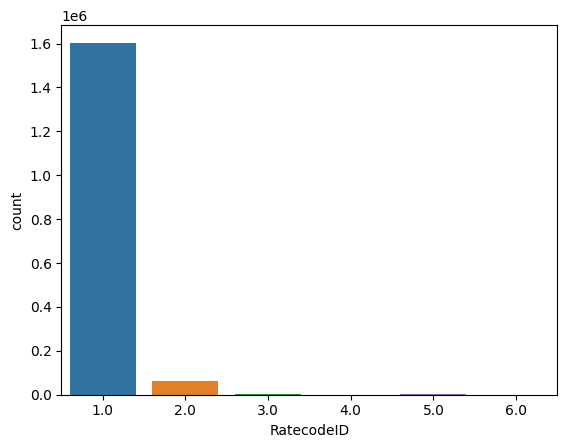

In [53]:
sns.countplot(df, x="RatecodeID")

<Axes: xlabel='payment_type', ylabel='count'>

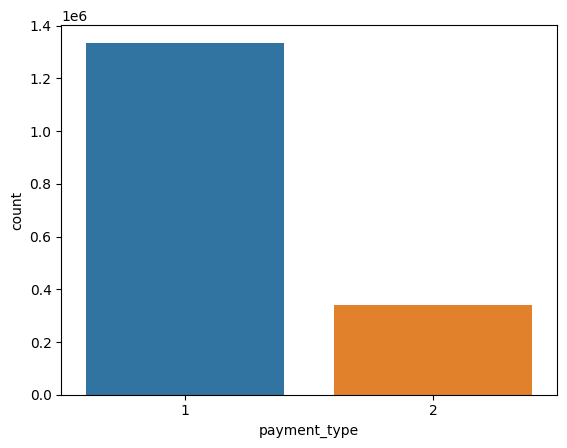

In [54]:
sns.countplot(df, x="payment_type")

<Axes: xlabel='PULocationID', ylabel='count'>

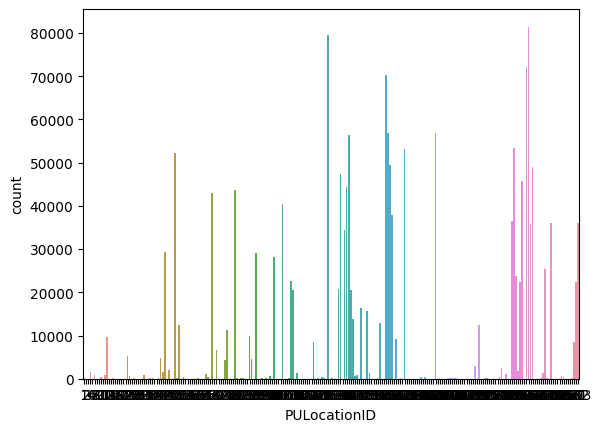

In [55]:
sns.countplot(df, x="PULocationID")

<Axes: xlabel='DOLocationID', ylabel='count'>

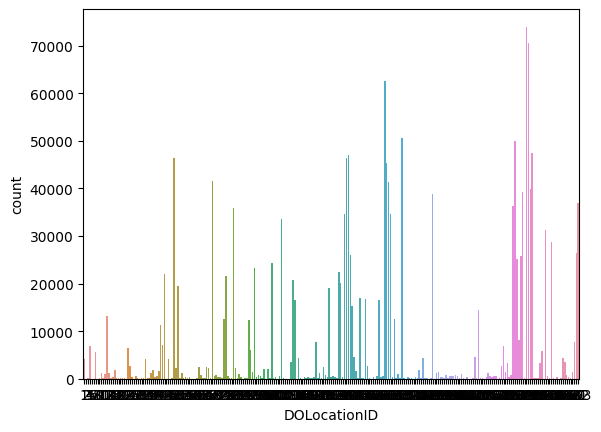

In [56]:
sns.countplot(df, x="DOLocationID")

### Plots Numericos (distribucion de los datos)

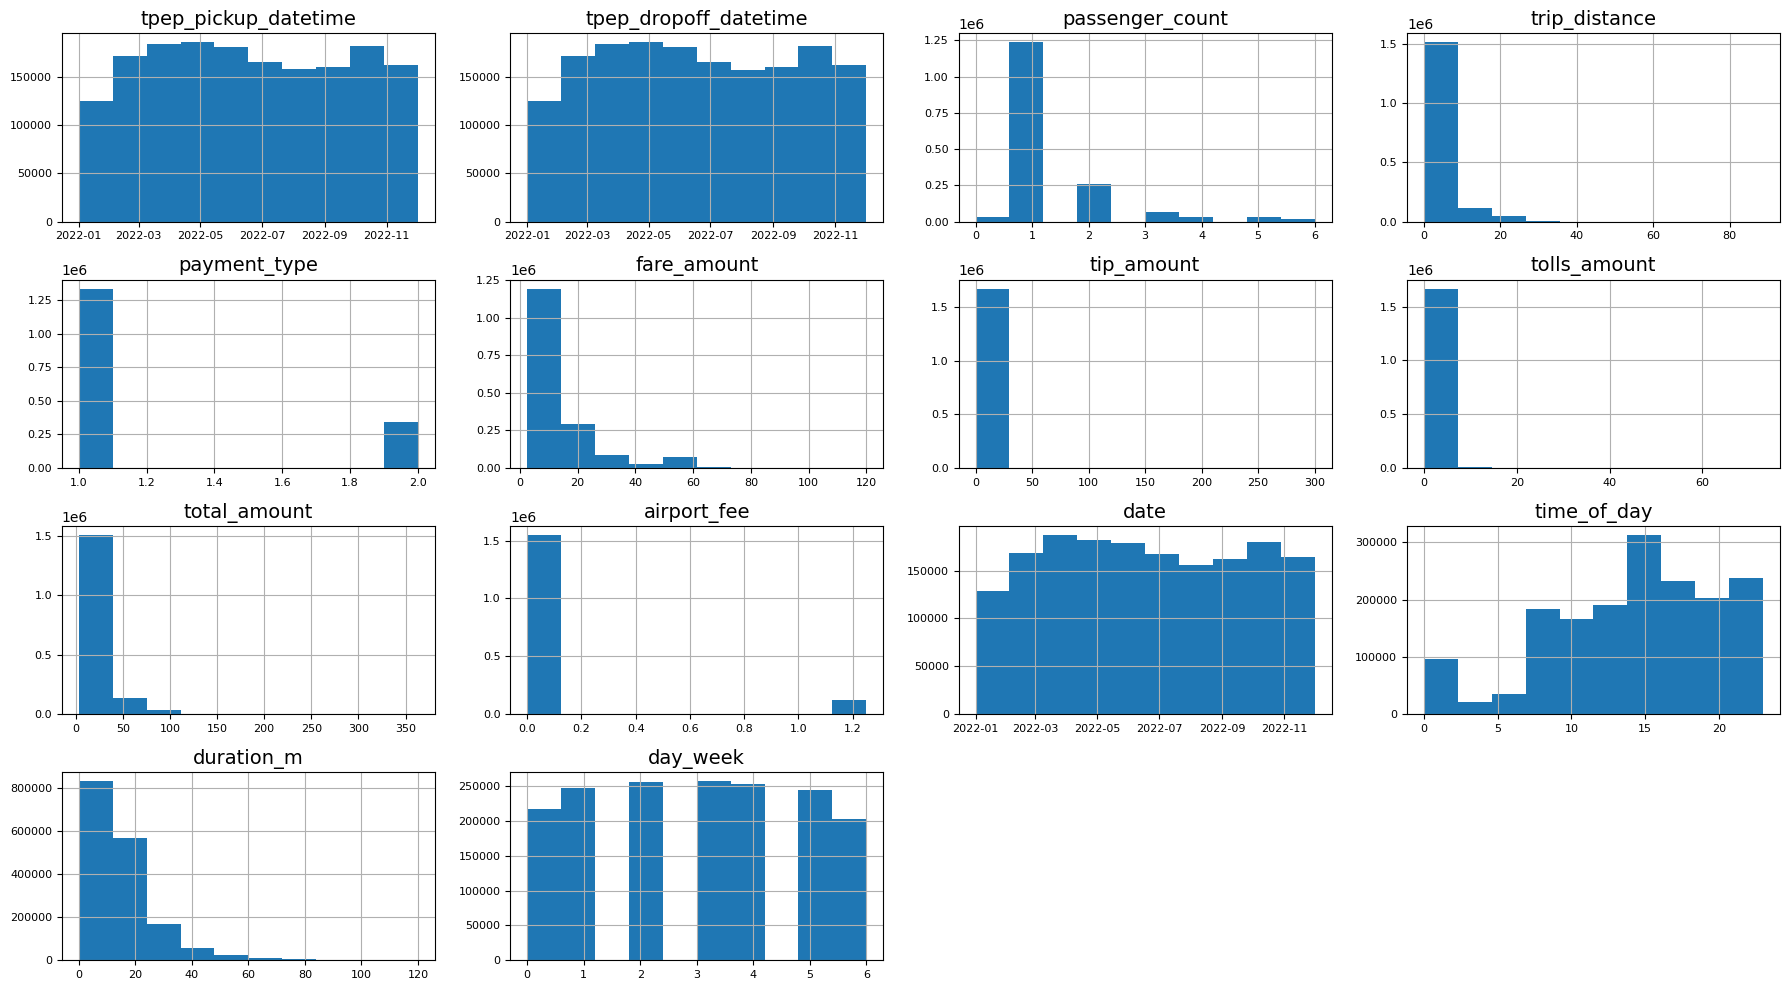

In [57]:
display_dataset_distributions(df)

In [58]:
df.total_amount.median()

15.8

In [59]:
df.total_amount.mode()

0    11.3
Name: total_amount, dtype: float32

In [60]:
df.total_amount.mean()

20.75587

### Veamos total_amount cerca de la media

In [61]:
df.total_amount.value_counts()

11.300000     26191
10.800000     25936
11.800000     25919
12.360000     25150
10.300000     25126
              ...  
67.930000         1
34.029999         1
87.559998         1
112.720001        1
106.000000        1
Name: total_amount, Length: 7362, dtype: int64

# Graficando columnas numericas con mas detalle

In [62]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= numerical_columns, grid_shape=(2, 3), figsize=(20, 12))

## Plots de variables de fecha

<Axes: xlabel='day_week', ylabel='Count'>

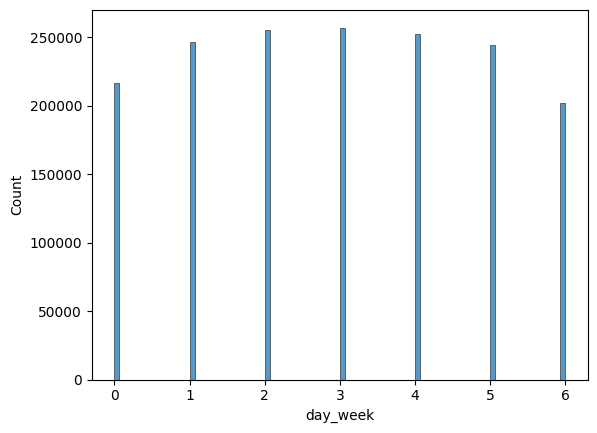

In [ ]:
sns.histplot(df["day_week"])

In [ ]:
date_columns = ["duration_m","time_of_day","day_week"]

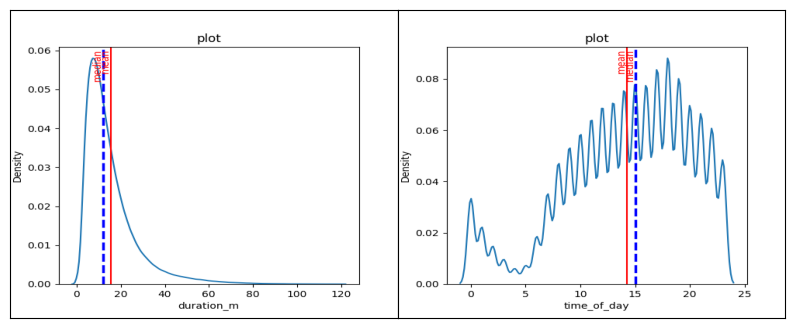

In [ ]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= date_columns[:-1], grid_shape=(1, 2), figsize=(10, 4))

In [ ]:
df['day_type'].value_counts()

workday    1194018
weekend     446092
holiday      35040
Name: day_type, dtype: int64

In [ ]:
holidays = df[df['day_type']=='holiday'].reset_index(drop = True)
weekends = df[df['day_type']=='weekend'].reset_index(drop = True)
workdays =     df[df['day_type']=='workday'].reset_index(drop = True)

In [ ]:
trip_filter_holiday = holidays[(holidays["trip_distance"]<=50)]["trip_distance"]
trip_filter_weekends = weekends[(weekends["trip_distance"]<=50)]["trip_distance"]
trip_filter_workday = workdays[(workdays["trip_distance"]<=50)]["trip_distance"]

In [ ]:
day_type_plots = [{"holidays":holidays,"filter":trip_filter_holiday},{"weekends":weekends,"filter":trip_filter_weekends},{"workdays":workdays,"filter":trip_filter_workday}]

In [ ]:
def plot_multiple_distributions(df_plots: list[dict],fig = None, figsize: tuple = (10,5), col_name: str = None, ax = None):
  cols = len(df_plots)
  fig, axes = plt.subplots(1,cols, figsize=figsize)
  axes = axes.ravel()

  for ax in range(cols):
    keys = list(df_plots[ax].keys())
    filter = None
    if col_name is None:
      filter = df_plots[ax].get(keys[1])
    plot_distribution_with_info(df_plots[ax].get(keys[0]),col_name = col_name, filter = filter,   ax = axes[ax], title = keys[0] )

  plt.show()

## Ploteando distribuciones por tipo de dia

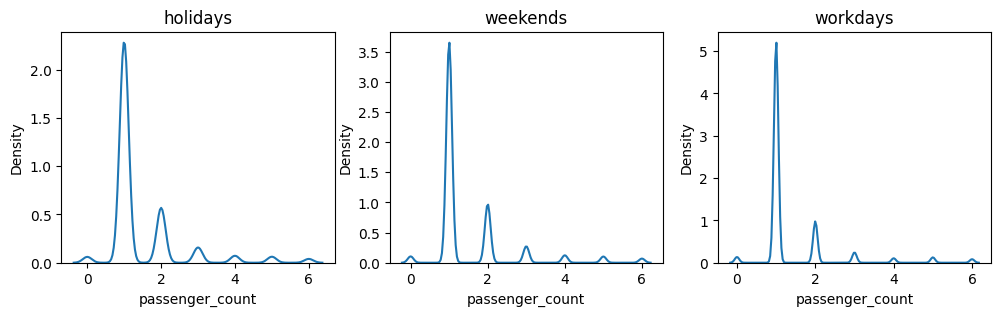

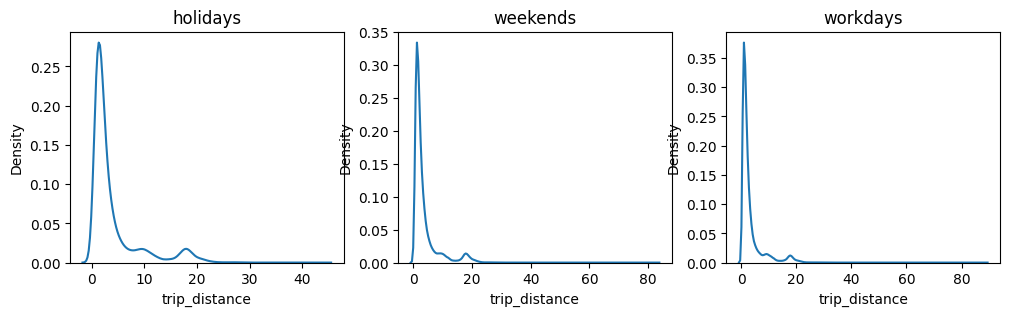

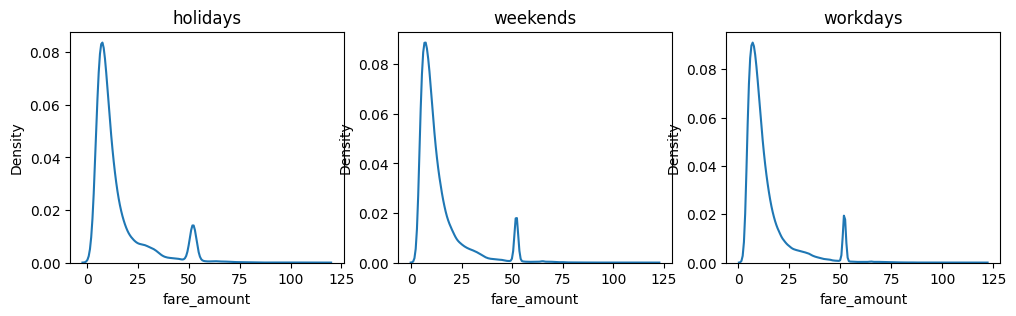

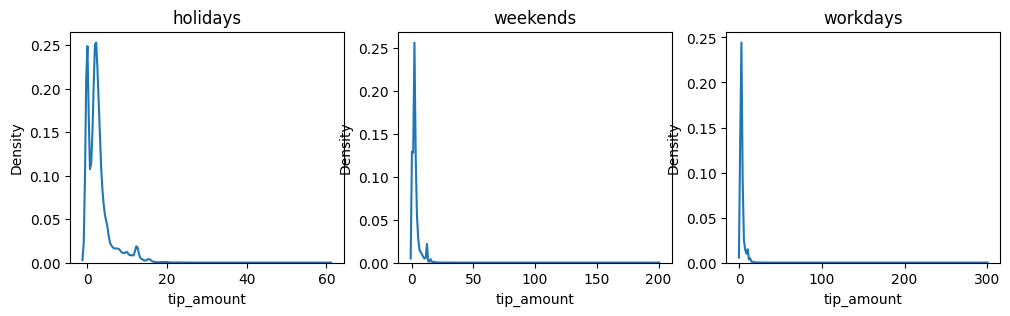

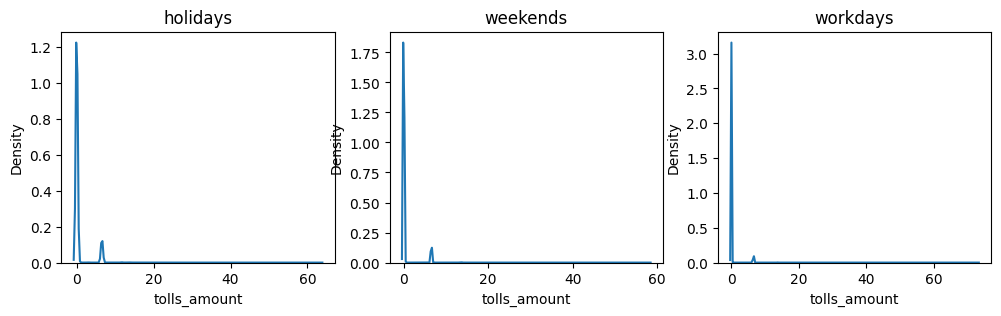

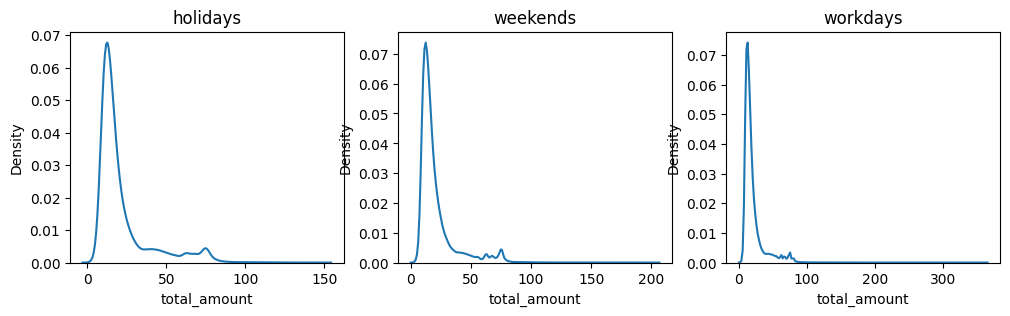

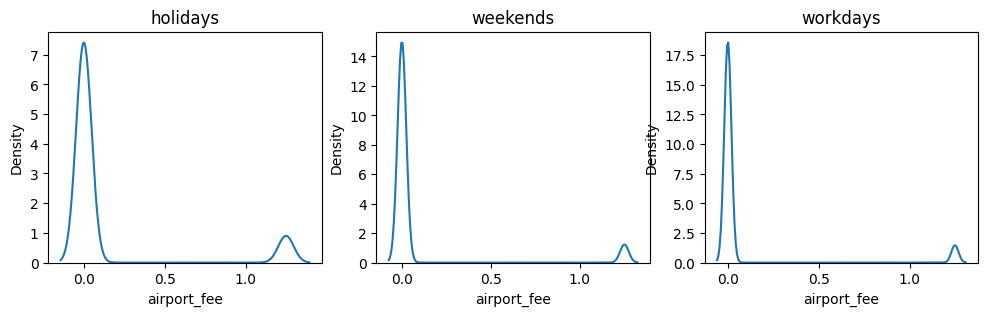

<Figure size 640x480 with 0 Axes>

In [ ]:
for c in numerical_columns:
  plot_multiple_distributions(day_type_plots, figsize = (12,3), col_name = c)
plt.tight_layout()

## Utilizando data geografica

In [ ]:
merged_df = pd.merge(df, taxi_zones, left_on='PULocationID', right_on='LocationID')
merged_df = merged_df.drop(columns='LocationID')
merged_df = merged_df.rename(columns={'Borough': 'PU_borough', 'Zone': 'PU_zone', 'service_zone': 'PU_service_zone'})
merged_df = pd.merge(merged_df, taxi_zones, left_on='DOLocationID', right_on='LocationID')
merged_df = merged_df.drop(columns='LocationID')
merged_df = merged_df.rename(columns={'Borough': 'DO_borough', 'Zone': 'DO_zone', 'service_zone': 'DO_service_zone'})

In [ ]:
manhattan_df = merged_df[(merged_df['PU_borough']== "Manhattan")&(merged_df['DO_borough']== "Manhattan")]

In [ ]:
manhattan_df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'month',
       'duration_m', 'day_of_year', 'day_week', 'day_type', 'PU_borough',
       'PU_zone', 'PU_service_zone', 'DO_borough', 'DO_zone',
       'DO_service_zone'],
      dtype='object')

In [ ]:
manhattan_df = manhattan_df.drop(columns = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "RatecodeID", "tip_amount","fare_amount",\
                             "day_of_year", "tolls_amount","airport_fee","PU_service_zone","DO_service_zone","PU_zone", "DO_zone",\
                             "PU_borough","DO_borough","date","month", "day_week"])

In [ ]:
manhattan_df.to_parquet('./dataset_manhattan.parquet')

In [ ]:
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
do_zone = df.groupby(['DOLocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, geo_map, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, geo_map, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [ ]:
df.groupby(['PULocationID'], as_index=False).size()

PULocationID   size
0              1     71
1              2      2
2              3      1
3              4   1594
4              6      3
..           ...    ...
235          259      5
236          260    274
237          261   8403
238          262  22376
239          263  35995

[240 rows x 2 columns]

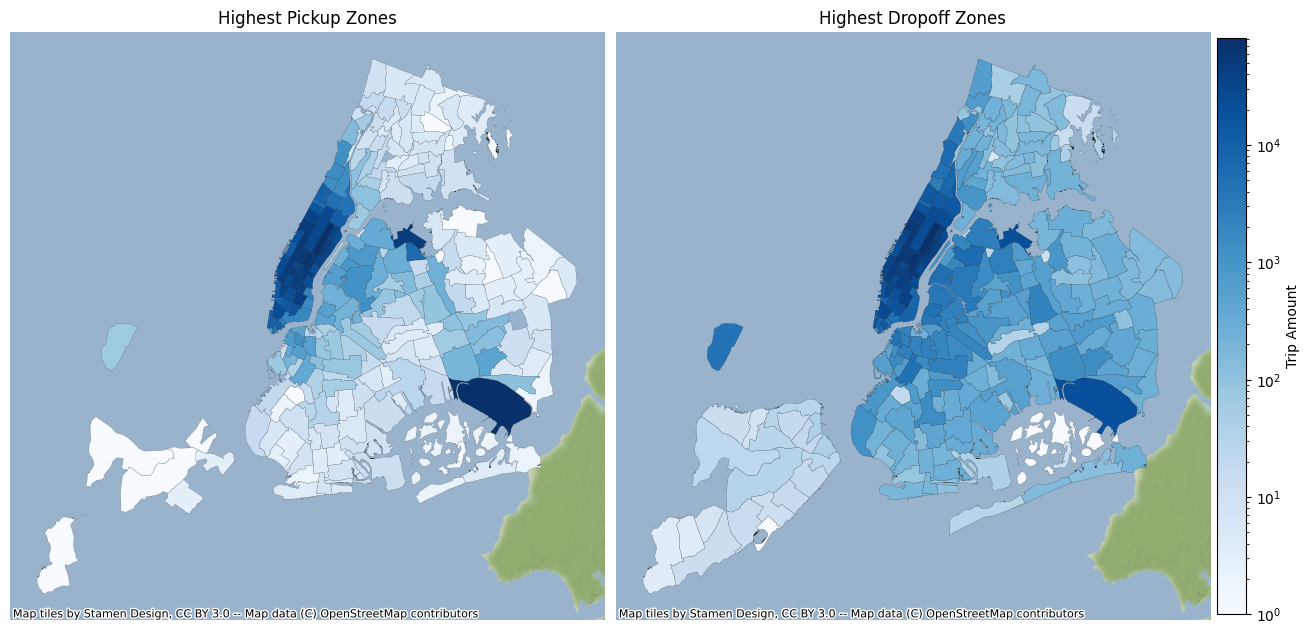

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
axs[0] = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_zone['size'].min(), do_zone['size'].max()
axs[1] = do_zone.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Highest Pickup Zones')
axs[1].set_title('Highest Dropoff Zones')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()

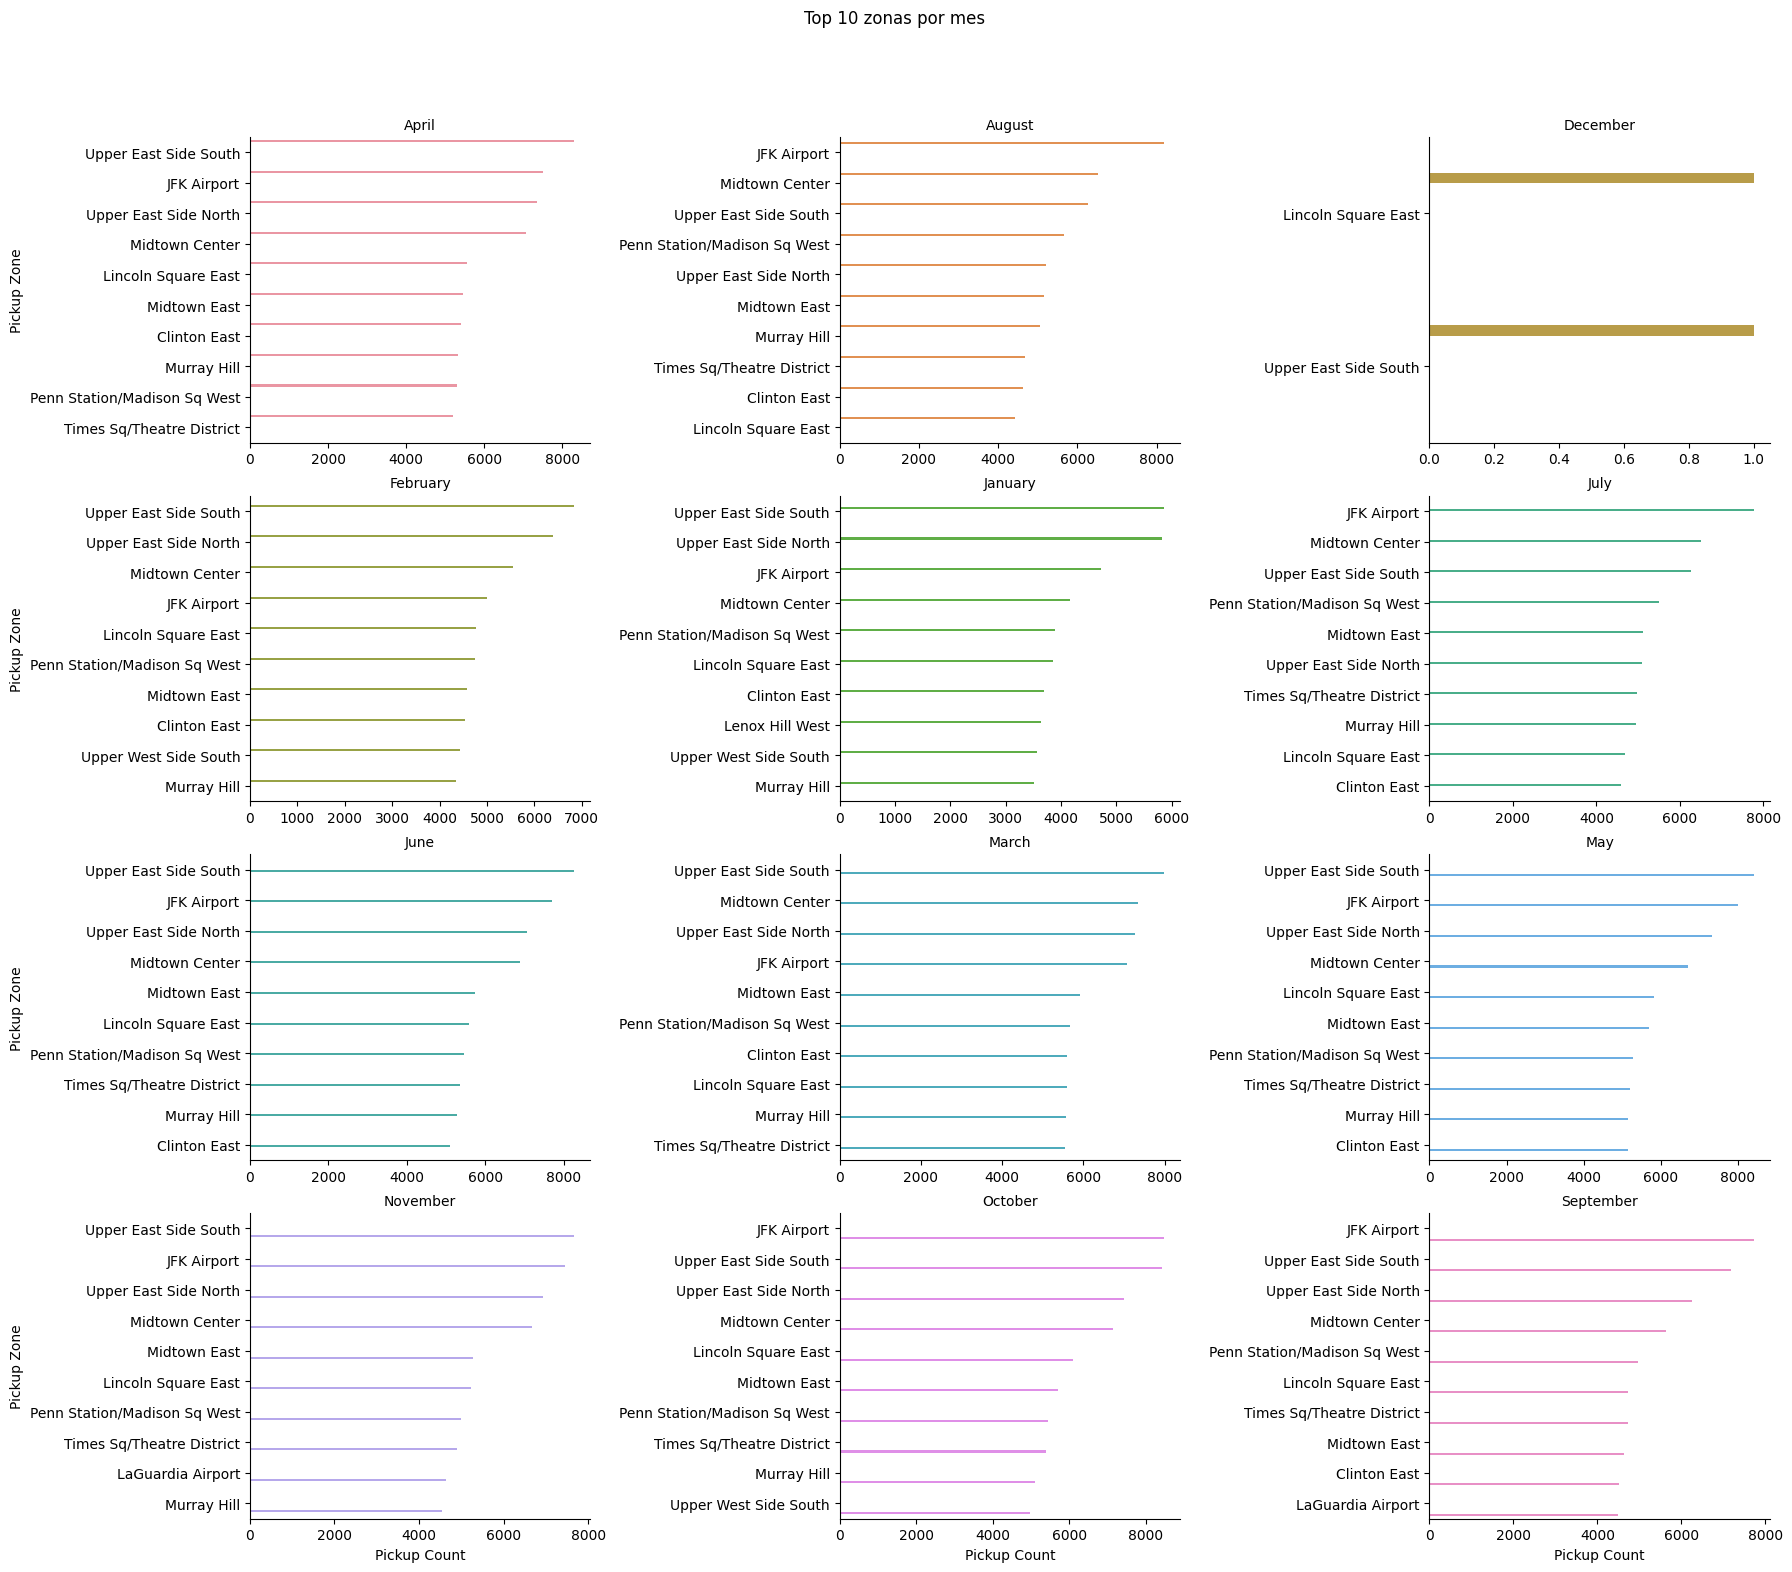

In [ ]:
zones_cols = ['PU_borough', 'PU_zone', 'PU_service_zone']
pickups_by_zone = merged_df.groupby(['month', *zones_cols]).size().reset_index(name='count')

pickups_by_zone = pickups_by_zone.sort_values(['month', 'count'], ascending=[True, False]).groupby('month').head(10)

fig = sns.catplot(x='count', y='PU_zone', hue='month', col='month', col_wrap=3, data=pickups_by_zone, kind='bar', height=4, aspect=1.5, sharex=False, sharey=False)
fig.fig.subplots_adjust(top=0.9)
fig.fig.suptitle('Top 10 zonas por mes')
fig.set_axis_labels('Pickup Count', 'Pickup Zone')
fig.set_titles('{col_name}')

for ax in fig.axes.flat:
    ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()


In [ ]:
day_type_agg = df.groupby('day_type')['PULocationID'].agg('count')

In [ ]:
numerical_columns.append('duration_m')

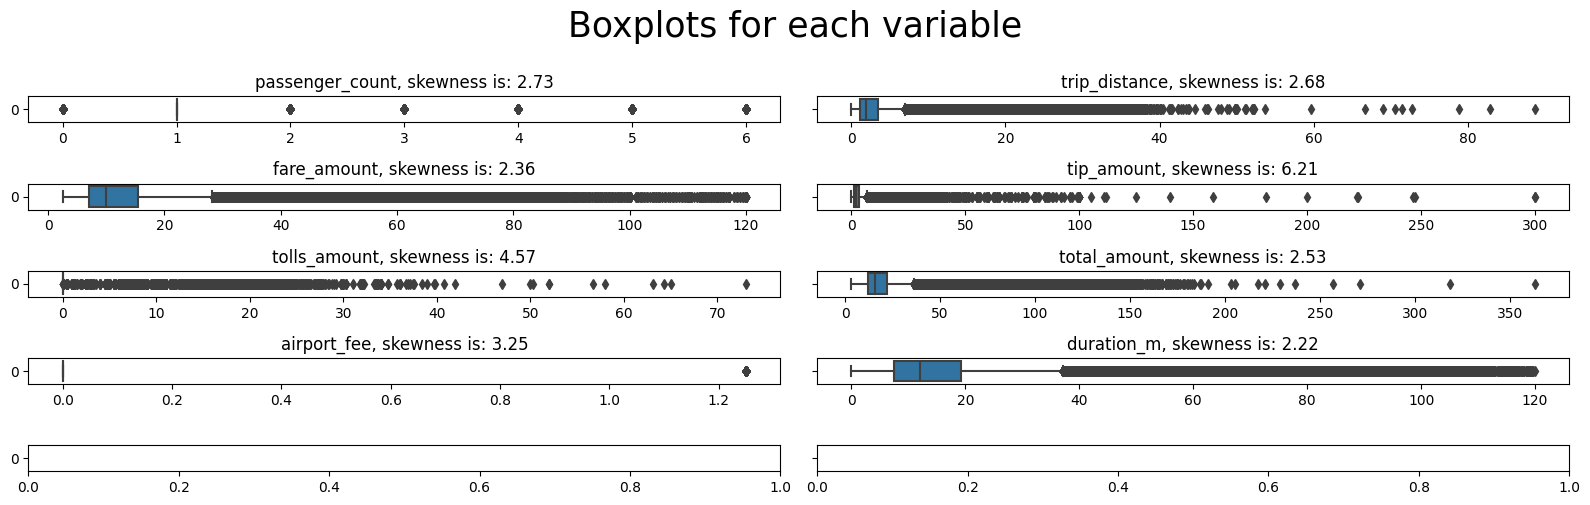

In [ ]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=5, cols=2, suptitle='Boxplots for each variable')
plt.tight_layout()

<Axes: xlabel='duration_m', ylabel='Density'>

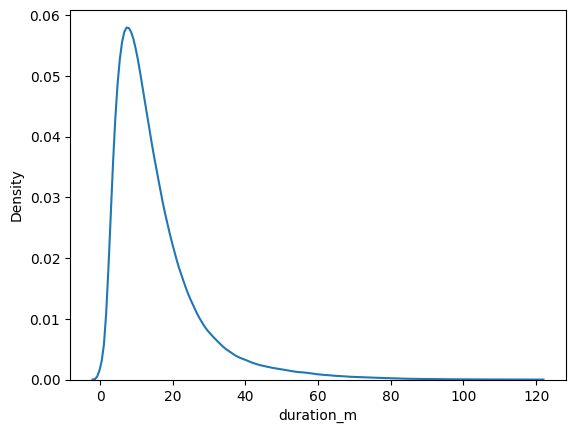

In [ ]:
sns.kdeplot(df['duration_m'])

In [ ]:
df['log_duration'] = df['duration_m'].apply(lambda x : np.log(x))

<Axes: xlabel='log_duration', ylabel='Density'>

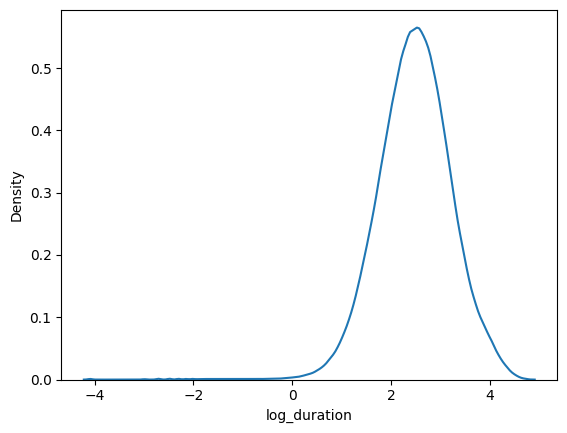

In [ ]:
sns.kdeplot(df['log_duration'])

## Normalizando 

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline 

In [ ]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'month',
       'duration_m', 'day_of_year', 'day_week', 'day_type', 'log_duration'],
      dtype='object')

In [ ]:
# $3.00 initial charge.
# Plus 70 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
# Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
# Plus $1.00 Improvement Surcharge.
# Plus $1.00 overnight surcharge 8pm to 6am.
# Plus $2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
# Plus New York State Congestion Surcharge of $2.50 (Yellow Taxi) or $2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
# Plus tips and any tolls.
# There is no charge for extra passengers, luggage or bags, or paying by credit card.
# The on-screen rate message should read: "Rate #01 – Standard City Rate."
# Make sure to always take your receipt.

In [ ]:
#df_filtered = merged_df[(merged_df["trip_distance"]<=40) & (merged_df["trip_distance"]>0)]

In [ ]:
df_filtered = merged_df.sample(int(np.floor(len(merged_df)/100)),random_state = 42)

In [ ]:
merged_df[merged_df['total_amount']>=100]

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2470     2022-11-18 17:23:03   2022-11-18 18:40:42              4.0   
2998     2022-01-12 12:39:04   2022-01-12 13:10:55              1.0   
9053     2022-05-18 09:04:24   2022-05-18 09:04:46              3.0   
9610     2022-08-09 00:20:27   2022-08-09 00:20:30              2.0   
50820    2022-04-09 17:23:02   2022-04-09 17:52:56              1.0   
...                      ...                   ...              ...   
1675130  2022-09-06 17:08:30   2022-09-06 18:27:19              2.0   
1675133  2022-05-22 08:56:19   2022-05-22 10:07:22              0.0   
1675134  2022-04-25 08:51:00   2022-04-25 10:01:16              1.0   
1675140  2022-07-27 22:32:07   2022-07-27 23:16:39              1.0   
1675141  2022-05-03 16:35:34   2022-05-03 18:02:10              2.0   

         trip_distance RatecodeID  PULocationID  DOLocationID  payment_type  \
2470         23.080000        2.0           132           161             1   
2998         17.410000        5.0           132           161             1   
9053          0.030000        5.0           161           161             1   
9610          0.110000        5.0           161           161             1   
50820         2.630000        1.0           249           161             1   
...                ...        ...           ...           ...           ...   
1675130      22.500000        1.0           170           109             1   
1675133      31.799999        1.0            50           109             2   
1675134      35.040001        1.0           138           109             1   
1675140      27.430000        1.0            87           204             1   
1675141      28.450001        1.0           162           204             1   

         fare_amount  tip_amount  ...  duration_m  day_of_year  day_week  \
2470            52.0   35.000000  ...   77.650002        11-18         4   
2998            75.0   16.870001  ...   31.850000        01-12         2   
9053            96.0   24.959999  ...    0.366667        05-18         2   
9610            85.0   17.059999  ...    0.050000        08-09         1   
50820           18.0  158.880005  ...   29.900000        04-09         5   
...              ...         ...  ...         ...          ...       ...   
1675130         70.5   10.000000  ...   78.816666        09-06         1   
1675133         91.5    0.000000  ...   71.050003        05-22         6   
1675134         96.5    0.000000  ...   70.266670        04-25         0   
1675140         74.0   24.020000  ...   44.533333        07-27         2   
1675141         87.0   20.879999  ...   86.599998        05-03         1   

        day_type  PU_borough                   PU_zone  PU_service_zone  \
2470     workday      Queens               JFK Airport         Airports   
2998     workday      Queens               JFK Airport         Airports   
9053     workday   Manhattan            Midtown Center      Yellow Zone   
9610     workday   Manhattan            Midtown Center      Yellow Zone   
50820    weekend   Manhattan              West Village      Yellow Zone   
...          ...         ...                       ...              ...   
1675130  workday   Manhattan               Murray Hill      Yellow Zone   
1675133  weekend   Manhattan              Clinton West      Yellow Zone   
1675134  workday      Queens         LaGuardia Airport         Airports   
1675140  workday   Manhattan  Financial District North      Yellow Zone   
1675141  workday   Manhattan              Midtown East      Yellow Zone   

            DO_borough            DO_zone DO_service_zone  
2470         Manhattan     Midtown Center     Yellow Zone  
2998         Manhattan     Midtown Center     Yellow Zone  
9053         Manhattan     Midtown Center     Yellow Zone  
9610         Manhattan     Midtown Center     Yellow Zone  
50820        Manhattan     Midtown Center     Yellow Zone  
...                ...          

In [ ]:
df_filtered = df_filtered[df_filtered['total_amount']<100]

In [ ]:
df_filtered["log_duration"] = np.log(df_filtered["duration_m"] )

In [ ]:
manhattan_df["log_duration"]= np.log(manhattan_df["duration_m"] )
manhattan_df["log_trip"] = np.log(manhattan_df["trip_distance"] )

In [ ]:
df_filtered["log_trip"] = np.log(df_filtered["trip_distance"] )

<Axes: xlabel='trip_distance', ylabel='Density'>

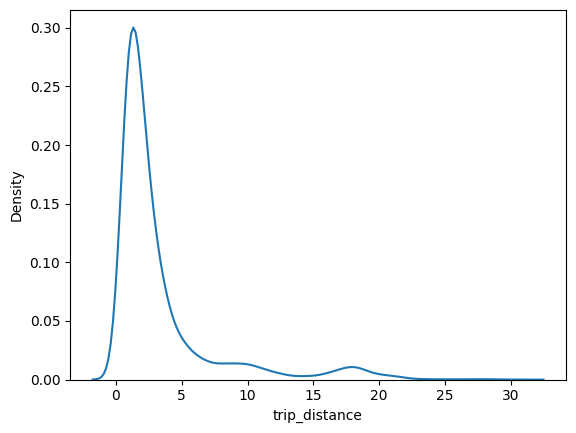

In [ ]:
sns.kdeplot(df_filtered['trip_distance'])

<Axes: xlabel='total_amount', ylabel='Density'>

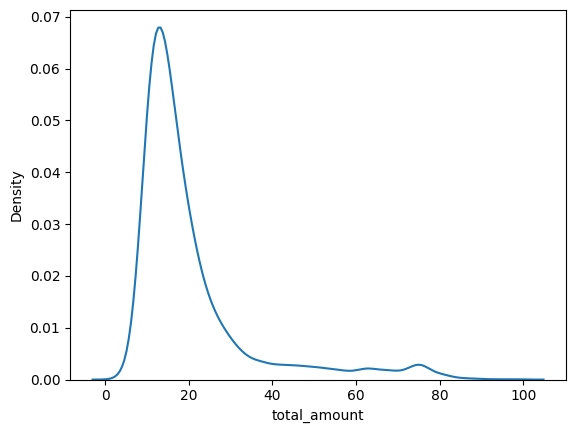

In [ ]:
sns.kdeplot(df_filtered['total_amount'])

In [ ]:
merged_df[(merged_df['fare_amount'] == 52)][["fare_amount","total_amount","PU_zone","DO_zone"]]

fare_amount  total_amount                   PU_zone          DO_zone
2462            52.0     80.050003               JFK Airport   Midtown Center
2463            52.0     68.099998               JFK Airport   Midtown Center
2464            52.0     63.099998               JFK Airport   Midtown Center
2465            52.0     63.099998               JFK Airport   Midtown Center
2466            52.0     73.099998               JFK Airport   Midtown Center
...              ...           ...                       ...              ...
1674783         52.0     75.720001               JFK Airport     Astoria Park
1675005         52.0     65.800003         Battery Park City        Bronxdale
1675108         52.0     61.849998  Financial District South  Mariners Harbor
1675119         52.0     66.360001                  Gramercy  Pelham Bay Park
1675137         52.0     68.400002      Flatbush/Ditmas Park      Great Kills

[63213 rows x 4 columns]

La razon por la que existe un pico en fare amount entre los 40-60 dolares es debido a la siguiente image obtenida de la siguiente fuete [trip savvy](https://www.tripsavvy.com/getting-to-and-from-jfk-airport-1612053) ya que la data es del 2022, durante este mismo año en diciembre la comision de taxis y limosinas de Nueva York cambio ese costo a 70$ vease la pagina actual [abrir](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page#:~:text=%243.00%20initial%20charge.,Dutchess%2C%20Orange%20or%20Putnam%20Counties.)

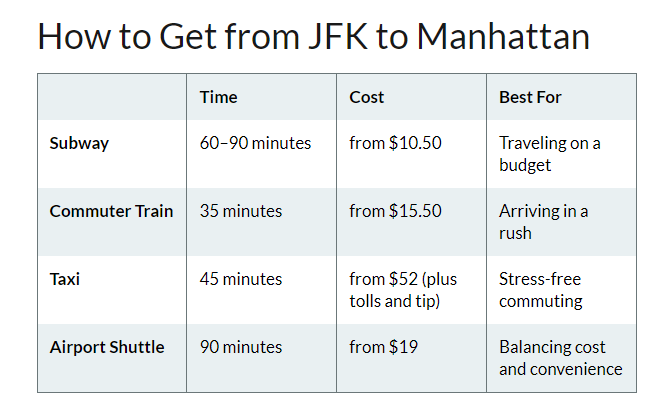

Este post de [bloomberg](https://www.bloomberg.com/news/articles/2022-11-15/nyc-taxi-cab-fares-to-rise-23-in-first-increase-since-2012) de noviembre 2022 se muestra lo siguiente 

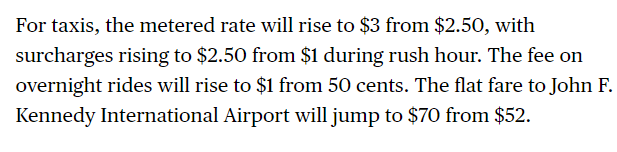

Segun la pagina oficial de la comision de nueva york estas son las tarifas, siendo de interes el cargo inicial de 3 dolares actual, para nuestra data seriade 2.5 dolares, por lo tanto se debe de crear un filtro de fare_amount para exlcluir valores menores a este cargo

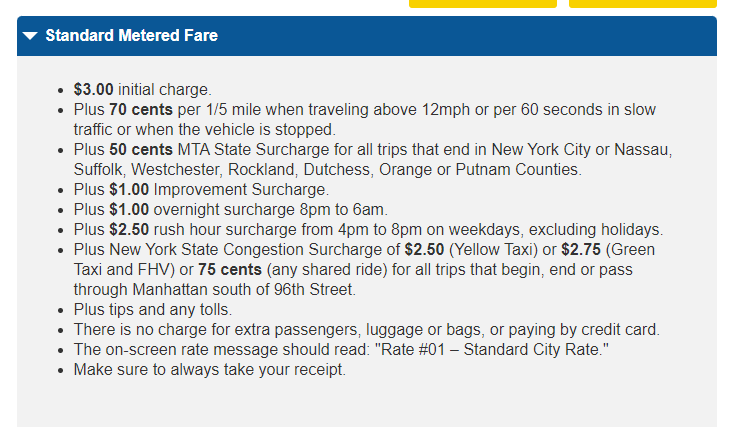

<Axes: xlabel='fare_amount', ylabel='Density'>

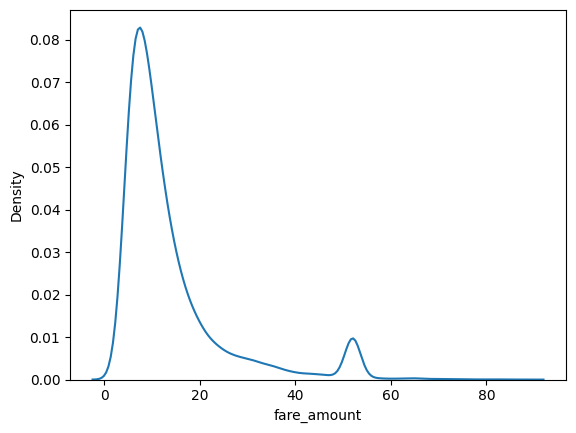

In [ ]:
sns.kdeplot(df_filtered['fare_amount'])

In [ ]:
df_filtered.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'month',
       'duration_m', 'day_of_year', 'day_week', 'day_type', 'PU_borough',
       'PU_zone', 'PU_service_zone', 'DO_borough', 'DO_zone',
       'DO_service_zone', 'log_duration', 'log_trip'],
      dtype='object')

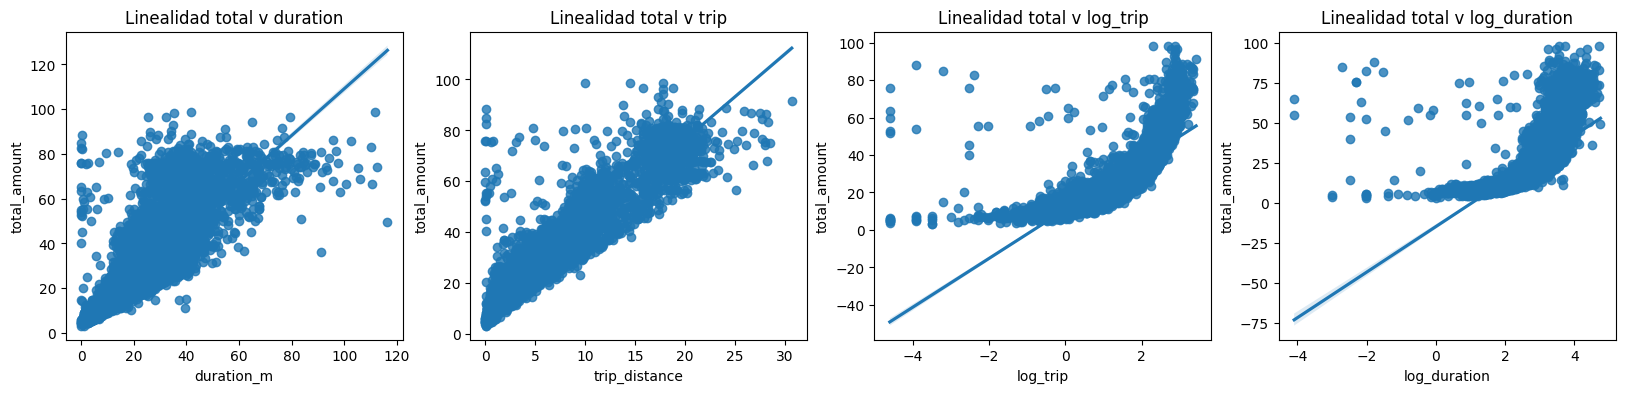

In [ ]:
fig,axes = plt.subplots(1,4,figsize=(20,4))
axes = axes.ravel()
sns.regplot(x="duration_m", y="total_amount", data=df_filtered, order=1,ax=axes[0]).set_title("Linealidad total v duration")
sns.regplot(x="trip_distance", y="total_amount", data=df_filtered, order=1,ax=axes[1]).set_title("Linealidad total v trip")
sns.regplot(x="log_trip", y="total_amount", data=df_filtered, order=1,ax=axes[2]).set_title("Linealidad total v log_trip")
sns.regplot(x="log_duration", y="total_amount", data=df_filtered, order=1,ax=axes[3]).set_title("Linealidad total v log_duration");

<ipython-input-107-17f610900467>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_filtered.corr(method = 'spearman').round(2)


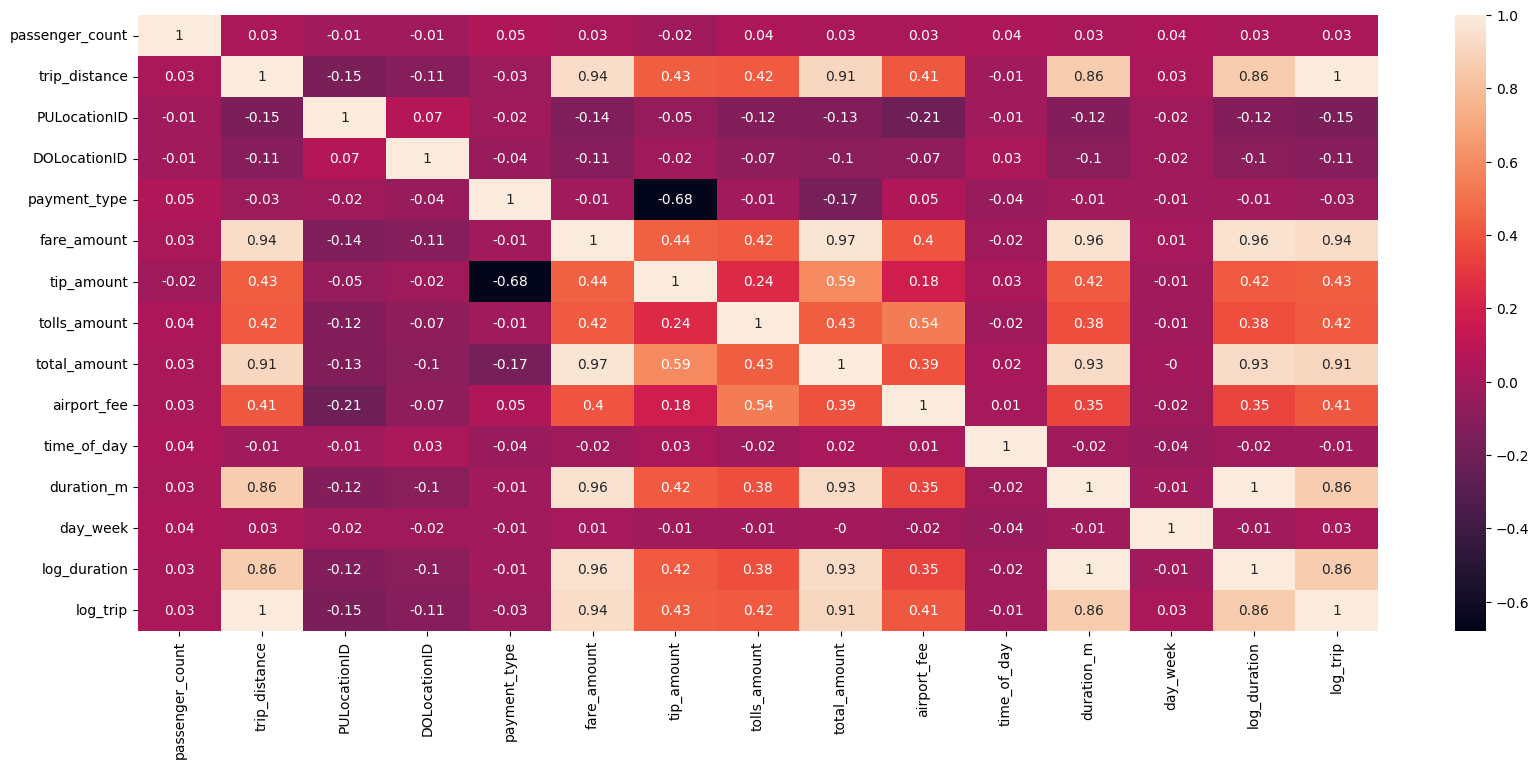

In [ ]:
correlation_matrix = df_filtered.corr(method = 'spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

In [ ]:
def transform_variable(df, col_name, method = "yeo-johnson"):
    power = PowerTransformer(method= method, standardize= True )
    if method == "box-cox":
      scaler = MinMaxScaler(feature_range=(1, 2))
      steps = [('s', scaler),('p', power)]
    else:
      steps = [('p', power)]
    #df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)

    pipeline = Pipeline(
        steps=steps
    )
    X_transformed = pipeline.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    sns.histplot(X_transformed, color='r', kde=True).set_title("{} con {}($\lambda={:2f}$)".format(
                  col_name,method, pipeline.named_steps['p'].lambdas_[0]) )
    return X_transformed 


array([[ 0.56251633],
       [ 2.3118932 ],
       [-0.5464826 ],
       ...,
       [ 0.9633384 ],
       [-0.39583018],
       [-0.45029104]], dtype=float32)

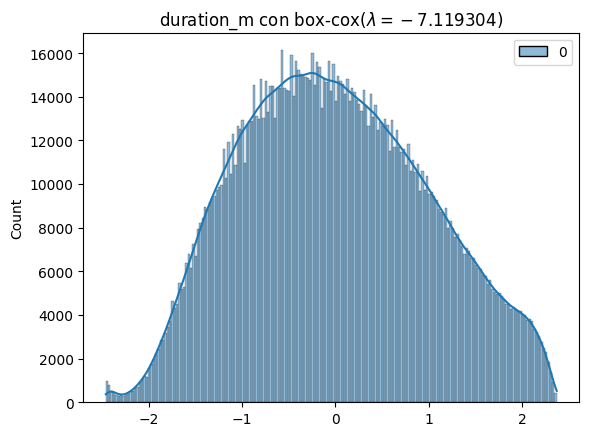

In [ ]:
transform_variable(df, "duration_m", "box-cox")

array([[ 0.52098185],
       [ 2.8862994 ],
       [-0.45647308],
       ...,
       [ 0.86978585],
       [-0.31465682],
       [-0.36536378]], dtype=float32)

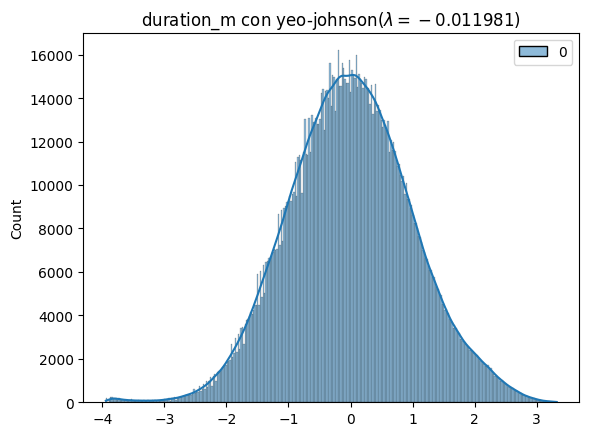

In [ ]:
transform_variable(df, "duration_m")

La transformacion de yeo-johnson se comporta mejor, veamos en la muestra

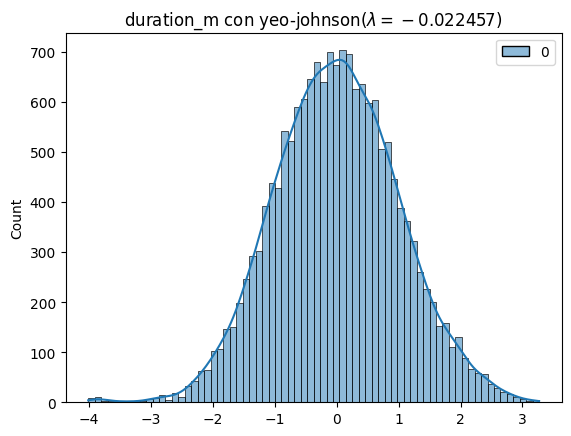

In [ ]:
df_filtered["duration_transformed"] = transform_variable(df_filtered, "duration_m")

## outliers

In [ ]:
def outlier_diagnostic_plots(df, col_name):
    import scipy.stats as stats
    fig, axes = plt.subplots(1,3,figsize=(20,4))
    #df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)
    sns.histplot(df[col_name], bins=30, ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    stats.probplot(df[col_name], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[col_name],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

Viendo outliers y plots QQ

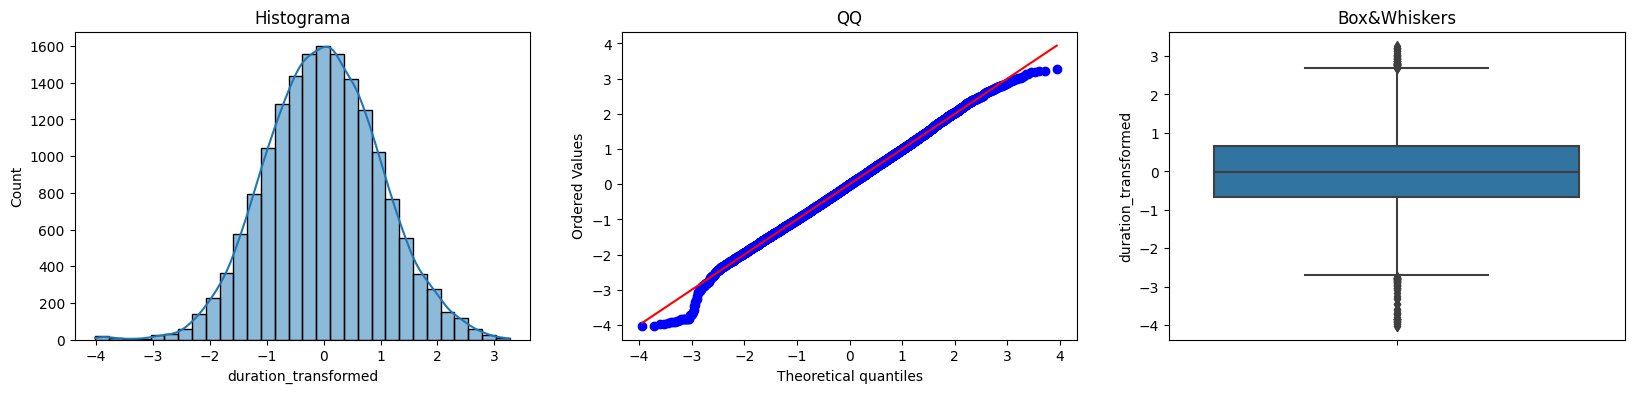

In [ ]:
outlier_diagnostic_plots(df_filtered, "duration_transformed")

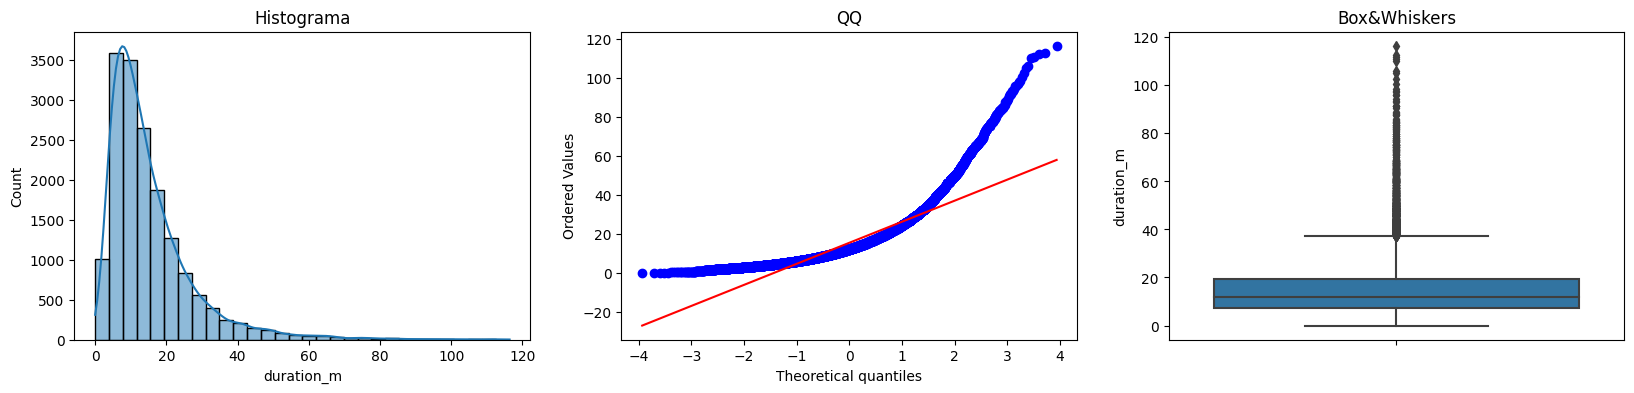

In [ ]:
outlier_diagnostic_plots(df_filtered, "duration_m")

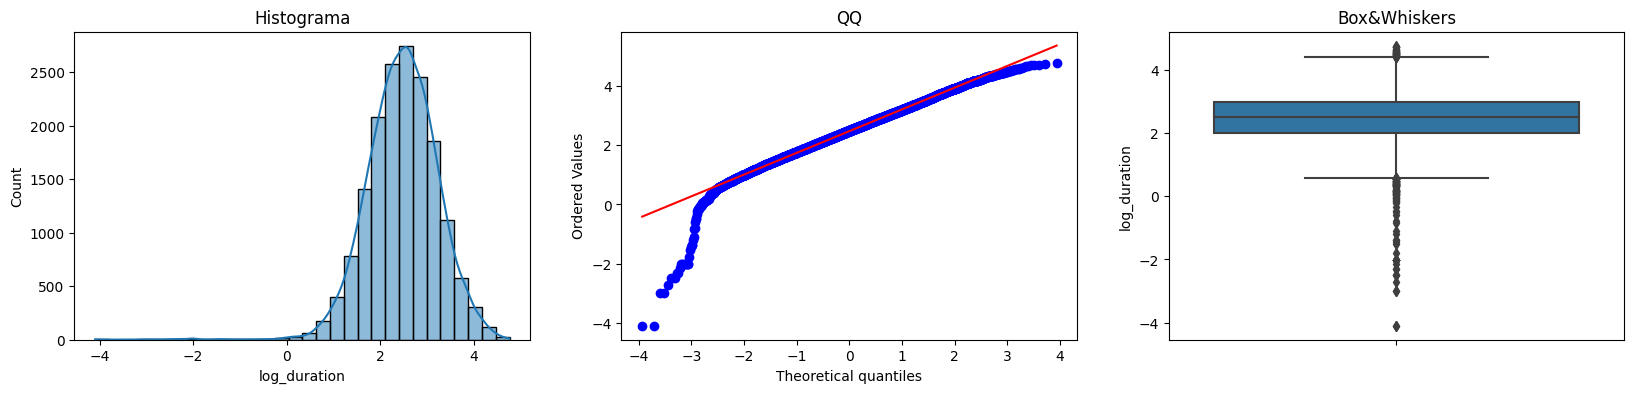

In [ ]:
outlier_diagnostic_plots(df_filtered, "log_duration")

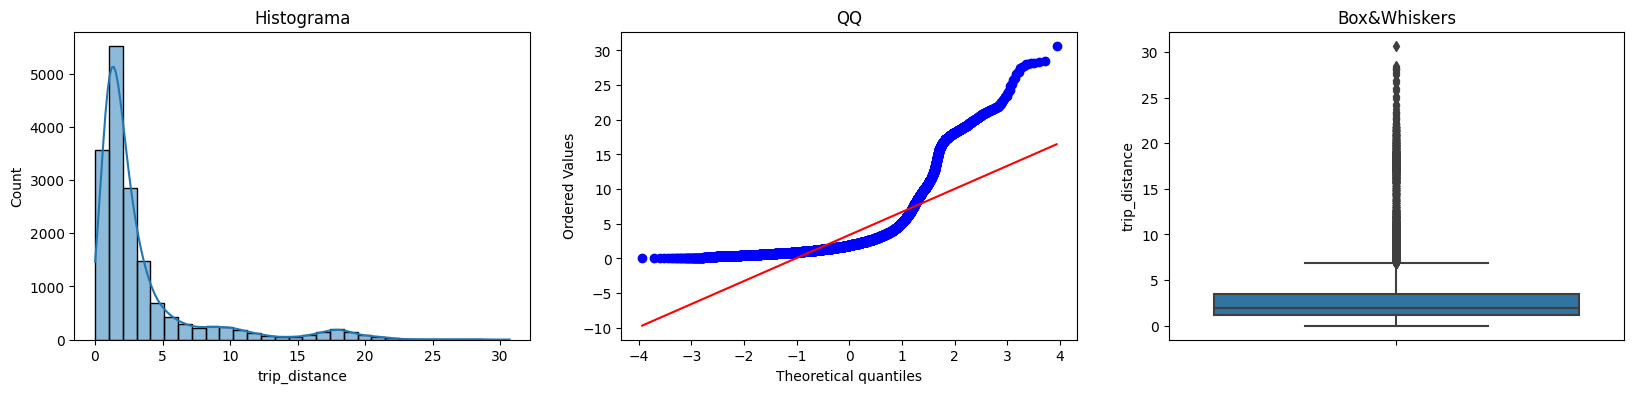

In [ ]:
outlier_diagnostic_plots(df_filtered, "trip_distance")

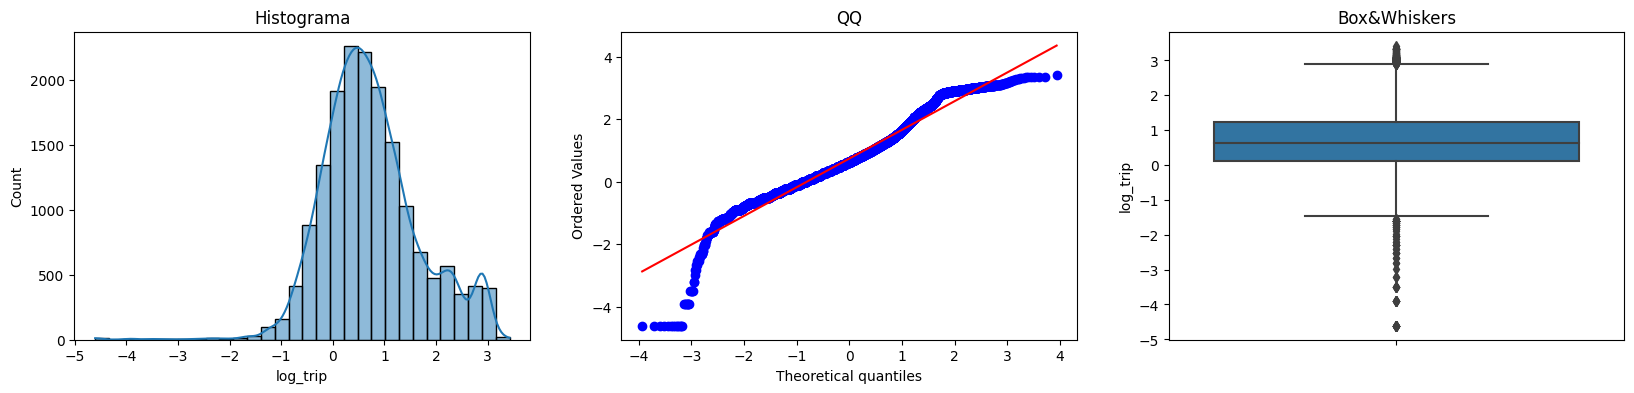

In [ ]:
outlier_diagnostic_plots(df_filtered, "log_trip")

array([[-1.2069476 ],
       [ 1.6269178 ],
       [-0.4412735 ],
       ...,
       [-0.16499685],
       [ 1.2383734 ],
       [ 0.09530862]], dtype=float32)

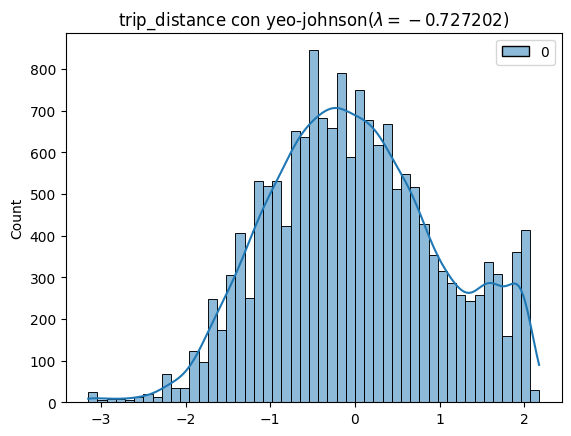

In [ ]:
transform_variable(df_filtered, "trip_distance")

## reduccion de outliers mediante distribucion normal aproximada por las tecnicas de transformacion anteriores

In [ ]:
def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()
    return upper_boundary, lower_boundary

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(df_filtered, 'duration_transformed')
upper_boundary, lower_boundary

(3.000089406625222, -3.0000894073091042)

In [ ]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [ ]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df_filtered, 'duration_transformed', 1.5)
RM_upper_limit, RM_lower_limit

(2.688242942094803, -2.6993100345134735)

In [ ]:
outliers_RM = np.where(df_filtered['duration_transformed'] > RM_upper_limit, True,
                       np.where(df_filtered['duration_transformed'] < RM_lower_limit, True, False))

La reduccion de outliers, elimino apenas el 0.0008% de la muestra

In [ ]:
df_trimmed = df_filtered.loc[~(outliers_RM), ]
df_filtered.shape, df_trimmed.shape

((16734, 29), (16616, 29))

In [ ]:
16633/16751

0.992955644439138

In [ ]:
df_filtered[df_filtered['duration_m']>=40]

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1326626  2022-10-14 16:53:31   2022-10-14 17:34:32              5.0   
1674417  2022-06-08 14:28:05   2022-06-08 15:16:26              1.0   
1661773  2022-09-10 16:39:36   2022-09-10 17:20:16              1.0   
1562144  2022-04-08 14:53:21   2022-04-08 15:47:16              1.0   
1628480  2022-10-30 00:49:13   2022-10-30 01:32:37              1.0   
...                      ...                   ...              ...   
151058   2022-07-14 07:16:13   2022-07-14 07:56:50              1.0   
1187478  2022-10-28 15:23:33   2022-10-28 16:16:06              1.0   
1519792  2022-06-11 16:59:50   2022-06-11 18:03:29              1.0   
1499275  2022-07-19 10:51:00   2022-07-19 11:45:02              1.0   
1608431  2022-07-02 19:10:01   2022-07-02 19:51:24              1.0   

         trip_distance RatecodeID  PULocationID  DOLocationID  payment_type  \
1326626      10.680000        1.0           231           138             1   
1674417      21.100000        1.0           132            46             1   
1661773       9.940000        1.0           138           218             2   
1562144       8.600000        1.0            75           256             1   
1628480       6.000000        1.0           246            49             1   
...                ...        ...           ...           ...           ...   
151058       16.809999        2.0           162           132             1   
1187478      16.330000        2.0           132           170             1   
1519792      14.550000        1.0           132             7             1   
1499275       8.460000        1.0           186           181             1   
1608431       7.860000        1.0           237            87             1   

         fare_amount  tip_amount  ...  day_type  PU_borough  \
1326626         35.0        8.11  ...   workday   Manhattan   
1674417         57.5        6.00  ...   workday      Queens   
1661773         33.0        0.00  ...   weekend      Queens   
1562144         36.5        5.00  ...   workday   Manhattan   
1628480         29.0        6.55  ...   weekend   Manhattan   
...              ...         ...  ...       ...         ...   
151058          52.0       10.00  ...   workday   Manhattan   
1187478         52.0       15.46  ...   workday      Queens   
1519792         54.0       11.21  ...   weekend      Queens   
1499275         38.0       10.32  ...   workday   Manhattan   
1608431         31.5        3.00  ...   weekend   Manhattan   

                              PU_zone PU_service_zone  DO_borough  \
1326626          TriBeCa/Civic Center     Yellow Zone      Queens   
1674417                   JFK Airport        Airports       Bronx   
1661773             LaGuardia Airport        Airports      Queens   
1562144             East Harlem South       Boro Zone    Brooklyn   
1628480     West Chelsea/Hudson Yards     Yellow Zone    Brooklyn   
...                               ...             ...         ...   
151058                   Midtown East     Yellow Zone      Queens   
1187478                   JFK Airport        Airports   Manhattan   
1519792                   JFK Airport        Airports      Queens   
1499275  Penn Station/Madison Sq West     Yellow Zone    Brooklyn   
1608431         Upper East Side South     Yellow Zone   Manhattan   

                           DO_zone  DO_service_zone log_duration  log_trip  \
1326626          LaGuardia Airport         Airports     3.713979  2.368373   
1674417                City Island        Boro Zone     3.878466  3.049273   
1661773  Springfield Gardens North        Boro Zone     3.705409  2.296567   
1562144  Williamsburg (South Side)        Boro Zone     3.987440  2.151762   
1628480               Clinton Hill        Boro Zone     3.770459  1.791759   
...                            ...              ...          ...       ...   
151058                 JFK Airport         Airports     3.704178  2.821974

In [ ]:
df_trimmed[df_trimmed['duration_m']>70]

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1656384  2022-10-03 08:09:44   2022-10-03 09:23:56              2.0   
563676   2022-05-07 16:28:32   2022-05-07 17:38:43              2.0   
562756   2022-09-14 09:58:11   2022-09-14 11:13:09              3.0   
1481035  2022-11-29 08:43:41   2022-11-29 09:54:42              1.0   
610078   2022-09-21 10:40:33   2022-09-21 11:56:53              2.0   
1647402  2022-10-19 16:05:48   2022-10-19 17:22:25              0.0   
1626485  2022-09-13 18:25:39   2022-09-13 19:42:49              1.0   
334428   2022-05-14 15:36:47   2022-05-14 16:48:11              1.0   
654503   2022-03-29 13:06:45   2022-03-29 14:19:19              1.0   
2730     2022-11-22 10:48:07   2022-11-22 12:01:04              2.0   
139944   2022-11-10 15:07:53   2022-11-10 16:22:07              1.0   
917917   2022-09-08 13:35:10   2022-09-08 14:50:15              1.0   
416668   2022-10-14 14:00:32   2022-10-14 15:12:25              1.0   
140044   2022-11-15 18:07:49   2022-11-15 19:18:46              1.0   
1415484  2022-11-11 16:29:40   2022-11-11 17:41:48              2.0   
154476   2022-07-21 18:32:24   2022-07-21 19:47:20              1.0   
1511271  2022-02-02 15:21:34   2022-02-02 16:32:23              2.0   
146335   2022-11-15 13:46:22   2022-11-15 15:01:43              1.0   
1186873  2022-04-05 07:43:59   2022-04-05 08:57:46              1.0   
1339705  2022-03-21 07:14:04   2022-03-21 08:26:37              2.0   
144674   2022-08-14 12:32:19   2022-08-14 13:42:25              2.0   
154133   2022-06-03 16:49:09   2022-06-03 18:04:27              2.0   
416522   2022-05-01 11:32:39   2022-05-01 12:49:16              1.0   
560810   2022-06-15 16:20:59   2022-06-15 17:34:06              4.0   
756456   2022-09-19 12:05:36   2022-09-19 13:23:00              0.0   
1649561  2022-06-01 16:27:02   2022-06-01 17:43:18              2.0   
1339632  2022-04-12 17:02:50   2022-04-12 18:20:38              1.0   
148334   2022-03-29 16:58:36   2022-03-29 18:13:02              3.0   
687300   2022-06-13 16:16:44   2022-06-13 17:29:47              2.0   
564002   2022-07-08 16:53:34   2022-07-08 18:05:42              2.0   
1339785  2022-05-26 13:02:52   2022-05-26 14:20:11              1.0   
993942   2022-10-25 16:42:30   2022-10-25 17:55:59              4.0   
466465   2022-11-11 16:18:50   2022-11-11 17:33:46              2.0   
1501771  2022-05-09 07:33:57   2022-05-09 08:48:49              1.0   
730846   2022-02-18 08:25:15   2022-02-18 09:38:44              1.0   
148862   2022-04-29 16:46:28   2022-04-29 18:03:40              2.0   
1607144  2022-08-20 09:57:21   2022-08-20 11:13:49              3.0   
935188   2022-03-25 07:20:18   2022-03-25 08:31:44              2.0   
141886   2022-06-02 09:39:11   2022-06-02 10:53:35              1.0   
560651   2022-05-13 11:34:34   2022-05-13 12:49:07              1.0   

         trip_distance RatecodeID  PULocationID  DOLocationID  payment_type  \
1656384      10.570000        1.0           197           106             1   
563676       18.709999        2.0           132           230             2   
562756       21.889999        2.0           132           230             2   
1481035      17.900000        2.0           132           114             1   
610078       17.330000        2.0           132           162             1   
1647402      13.700000        2.0           163           134             1   
1626485      25.900000        1.0           132           200             2   
334428       20.400000        2.0           132           239             1   
654503       18.830000        2.0           132           249             1   
2730         18.430000        2.0           132           161             1   
139944       15.690000        2.0           163           132             1   
917917       18.059999        2.0           132           144             1   
416668       18.910000        2.0           132           163        

<Axes: xlabel='duration_m', ylabel='Density'>

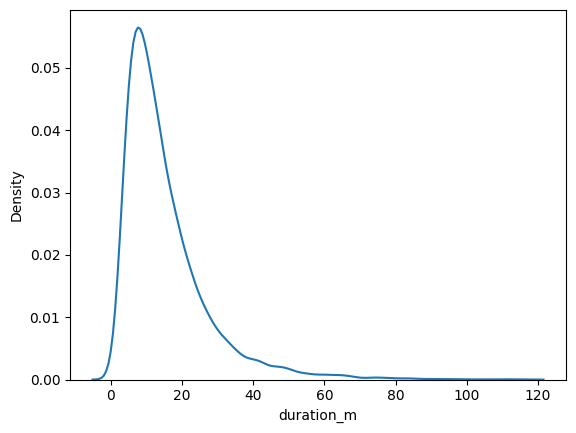

In [ ]:
sns.kdeplot(df_filtered['duration_m'])

<Axes: xlabel='duration_m', ylabel='Density'>

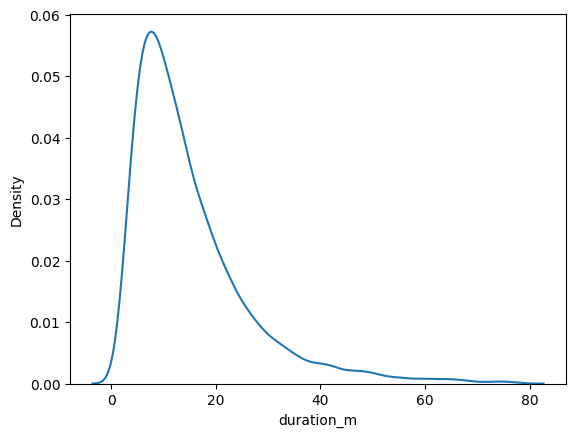

In [ ]:
sns.kdeplot(df_trimmed['duration_m'])

In [ ]:
numerical_columns

['passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'airport_fee',
 'duration_m']

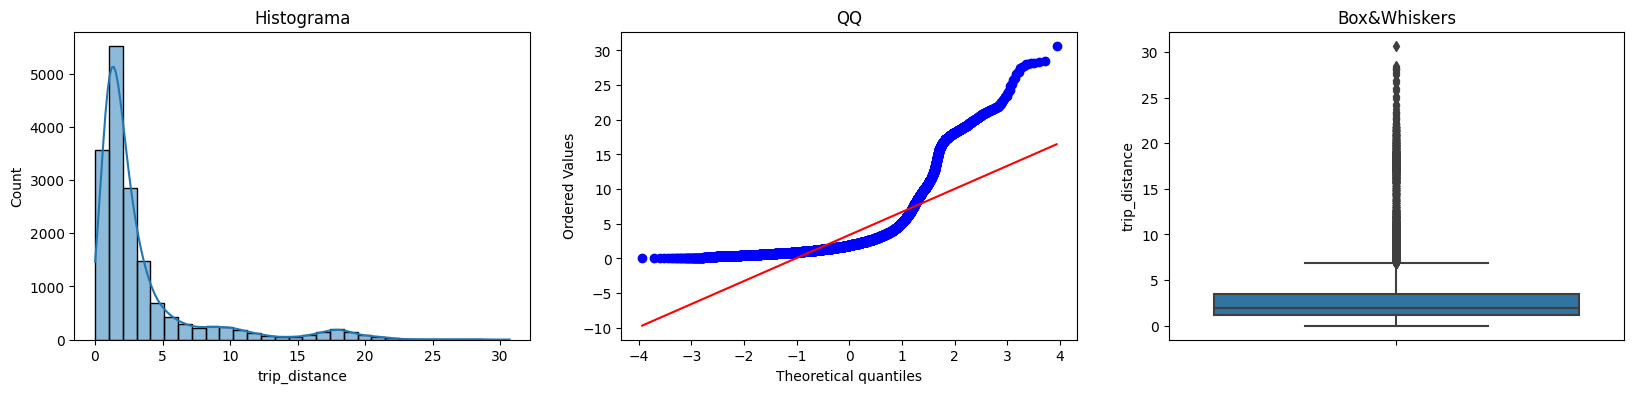

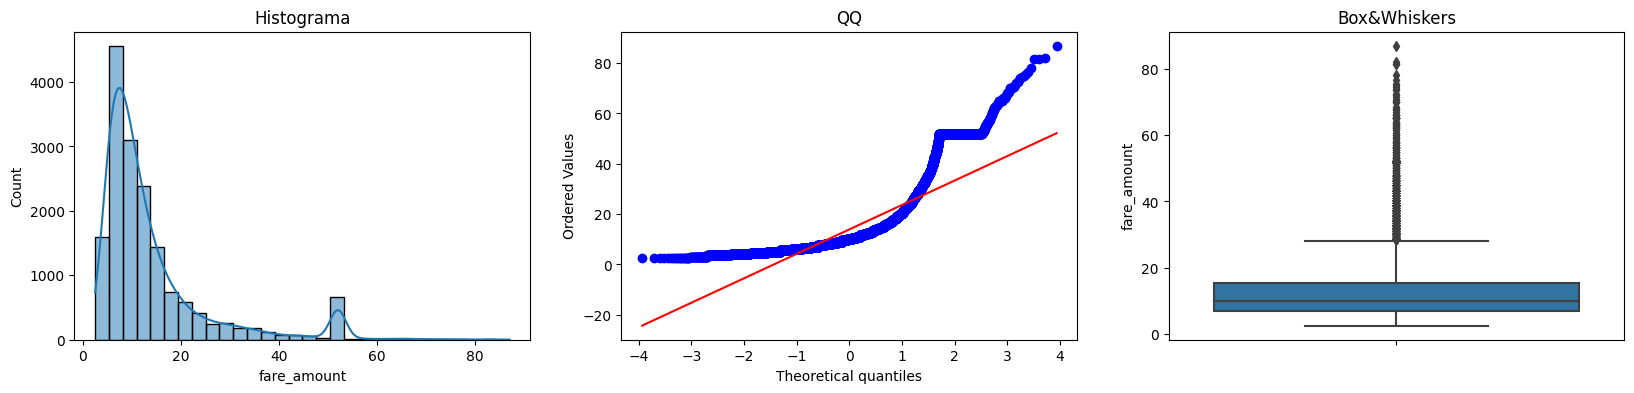

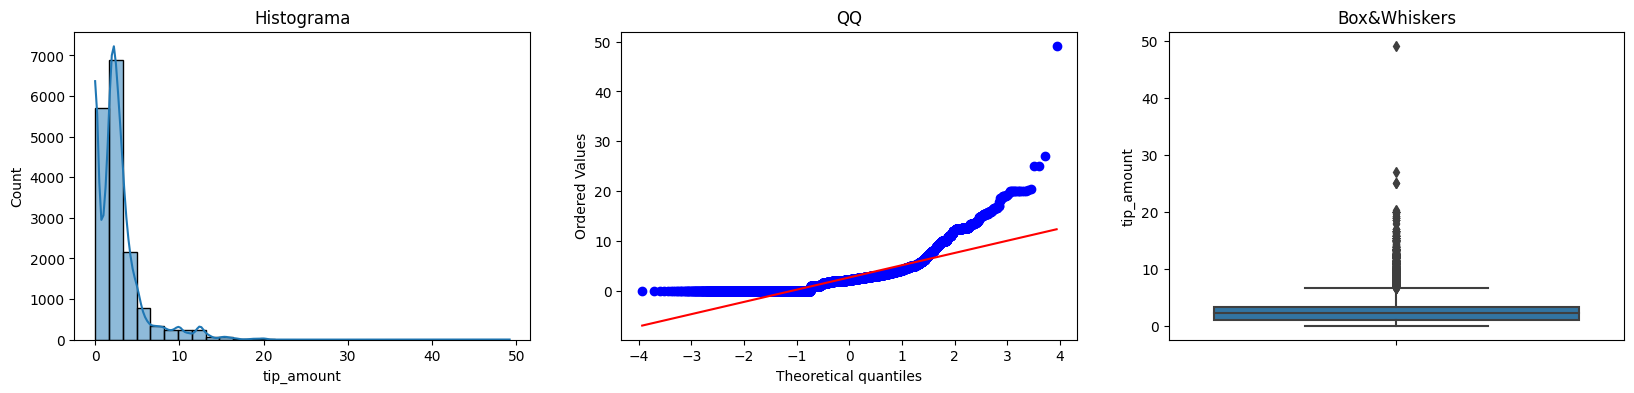

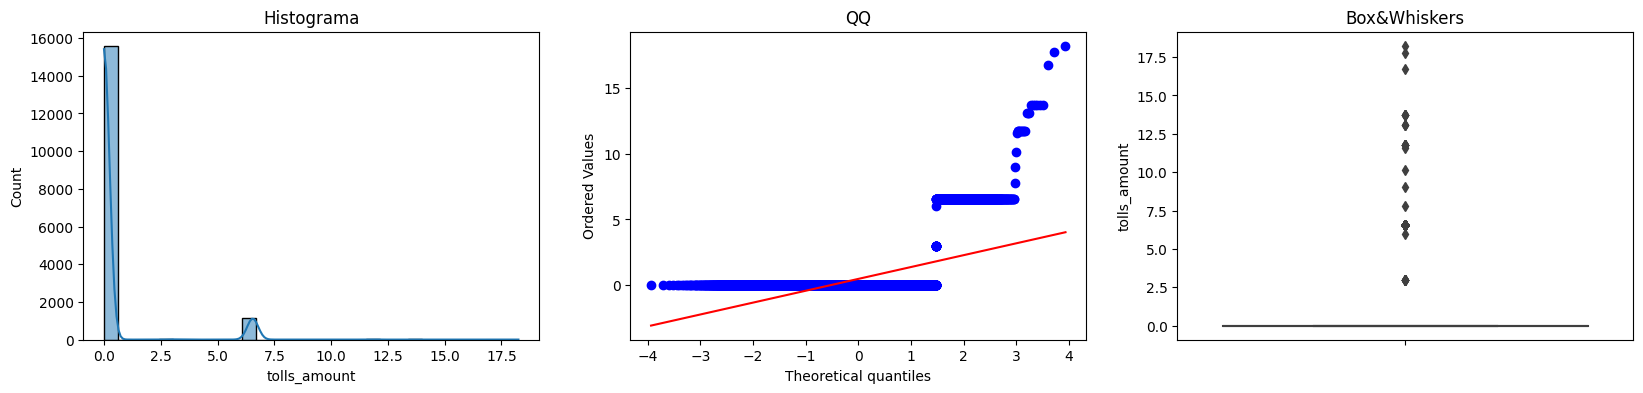

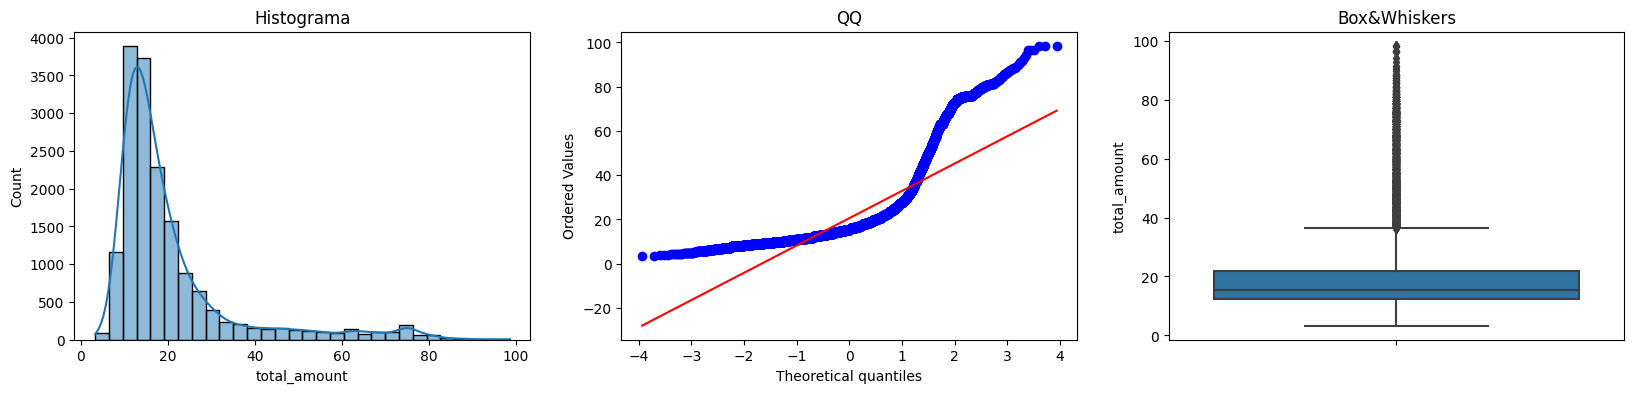

In [ ]:
for col in numerical_columns[1:-2:]:
  outlier_diagnostic_plots(df_filtered, col)

In [ ]:
def plot_by_pair(group, title = "", xlabel= "", ylabel= ""): 
  plt.plot(group.index, group.values)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.show()

In [ ]:
passenger_by_day = df.groupby(df['day_week'])['passenger_count'].mean()

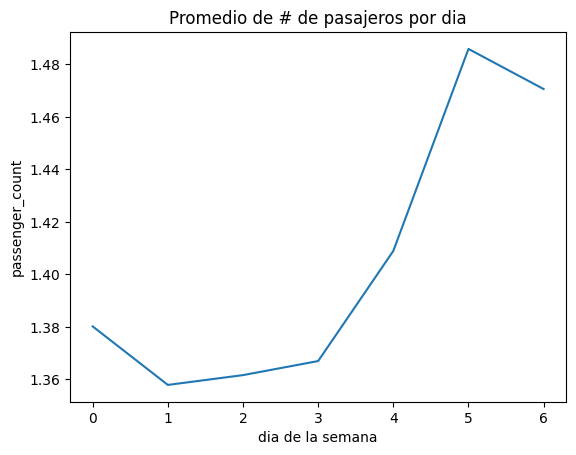

In [ ]:
plot_by_pair(passenger_by_day,'Promedio de # de pasajeros por dia','dia de la semana','passenger_count')

In [ ]:
duration_by_type = df.groupby(df['day_type'])['duration_m'].mean()

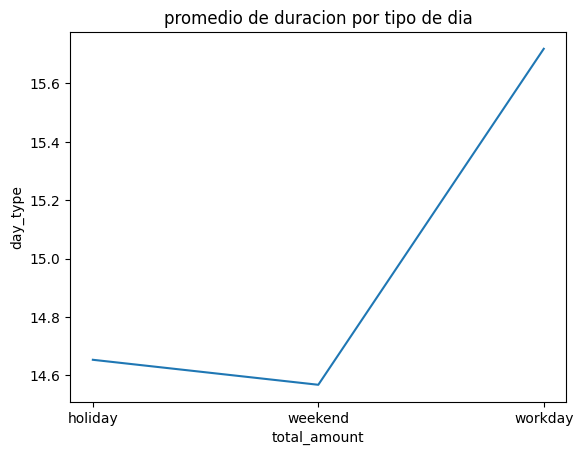

In [ ]:
plot_by_pair(duration_by_type, "promedio de duracion por tipo de dia", "total_amount", "day_type")

In [ ]:
total_by_type = df.groupby(df['day_type'])['total_amount'].mean()

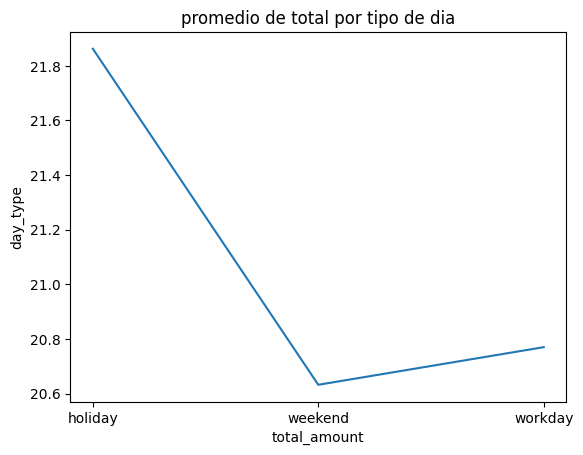

In [ ]:
plot_by_pair(total_by_type, "promedio de total por tipo de dia", "total_amount", "day_type")

In [ ]:
tip_by_hour = df.groupby(df['time_of_day'])['tip_amount'].mean()

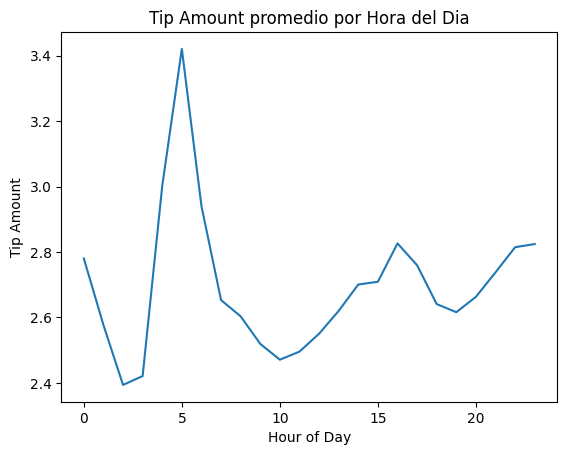

In [ ]:
plot_by_pair(tip_by_hour,'Tip Amount promedio por Hora del Dia','Hour of Day', 'Tip Amount')

<Axes: xlabel='day_type', ylabel='Count'>

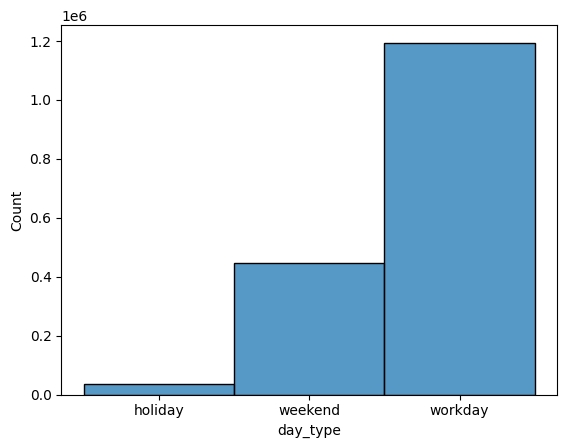

In [ ]:
sns.histplot(data = df, x= 'day_type')

<ipython-input-142-be8e7d4a6e7c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method = 'spearman').round(2)


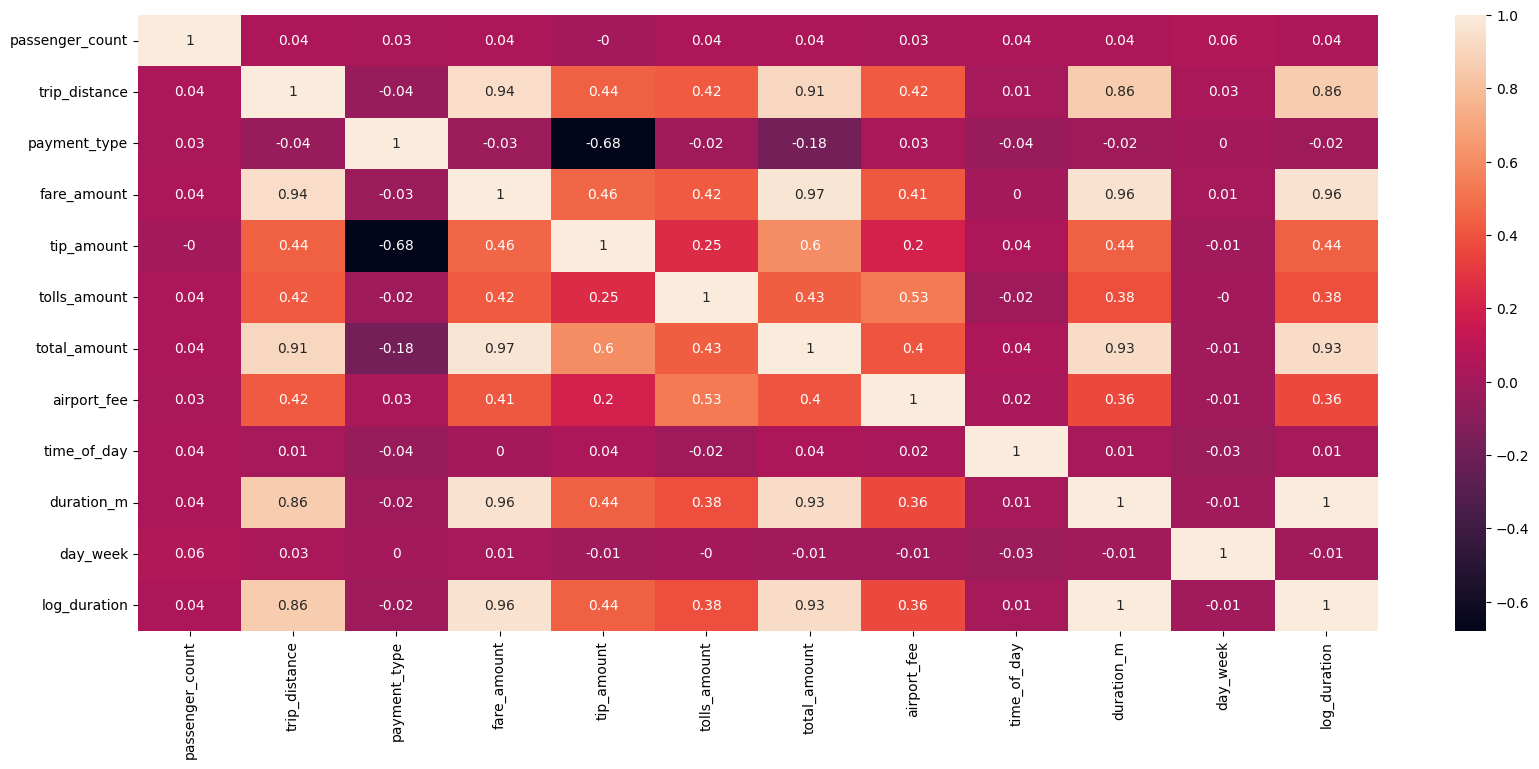

In [ ]:
correlation_matrix = df.corr(method = 'spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

In [ ]:
(total_max, total_min)=calculate_maxes(df,'total_amount')

In [ ]:
lonmin, latmin, lonmax, latmax = geo_map.total_bounds

Text(0.5, 1.0, 'Heatmap of payments')

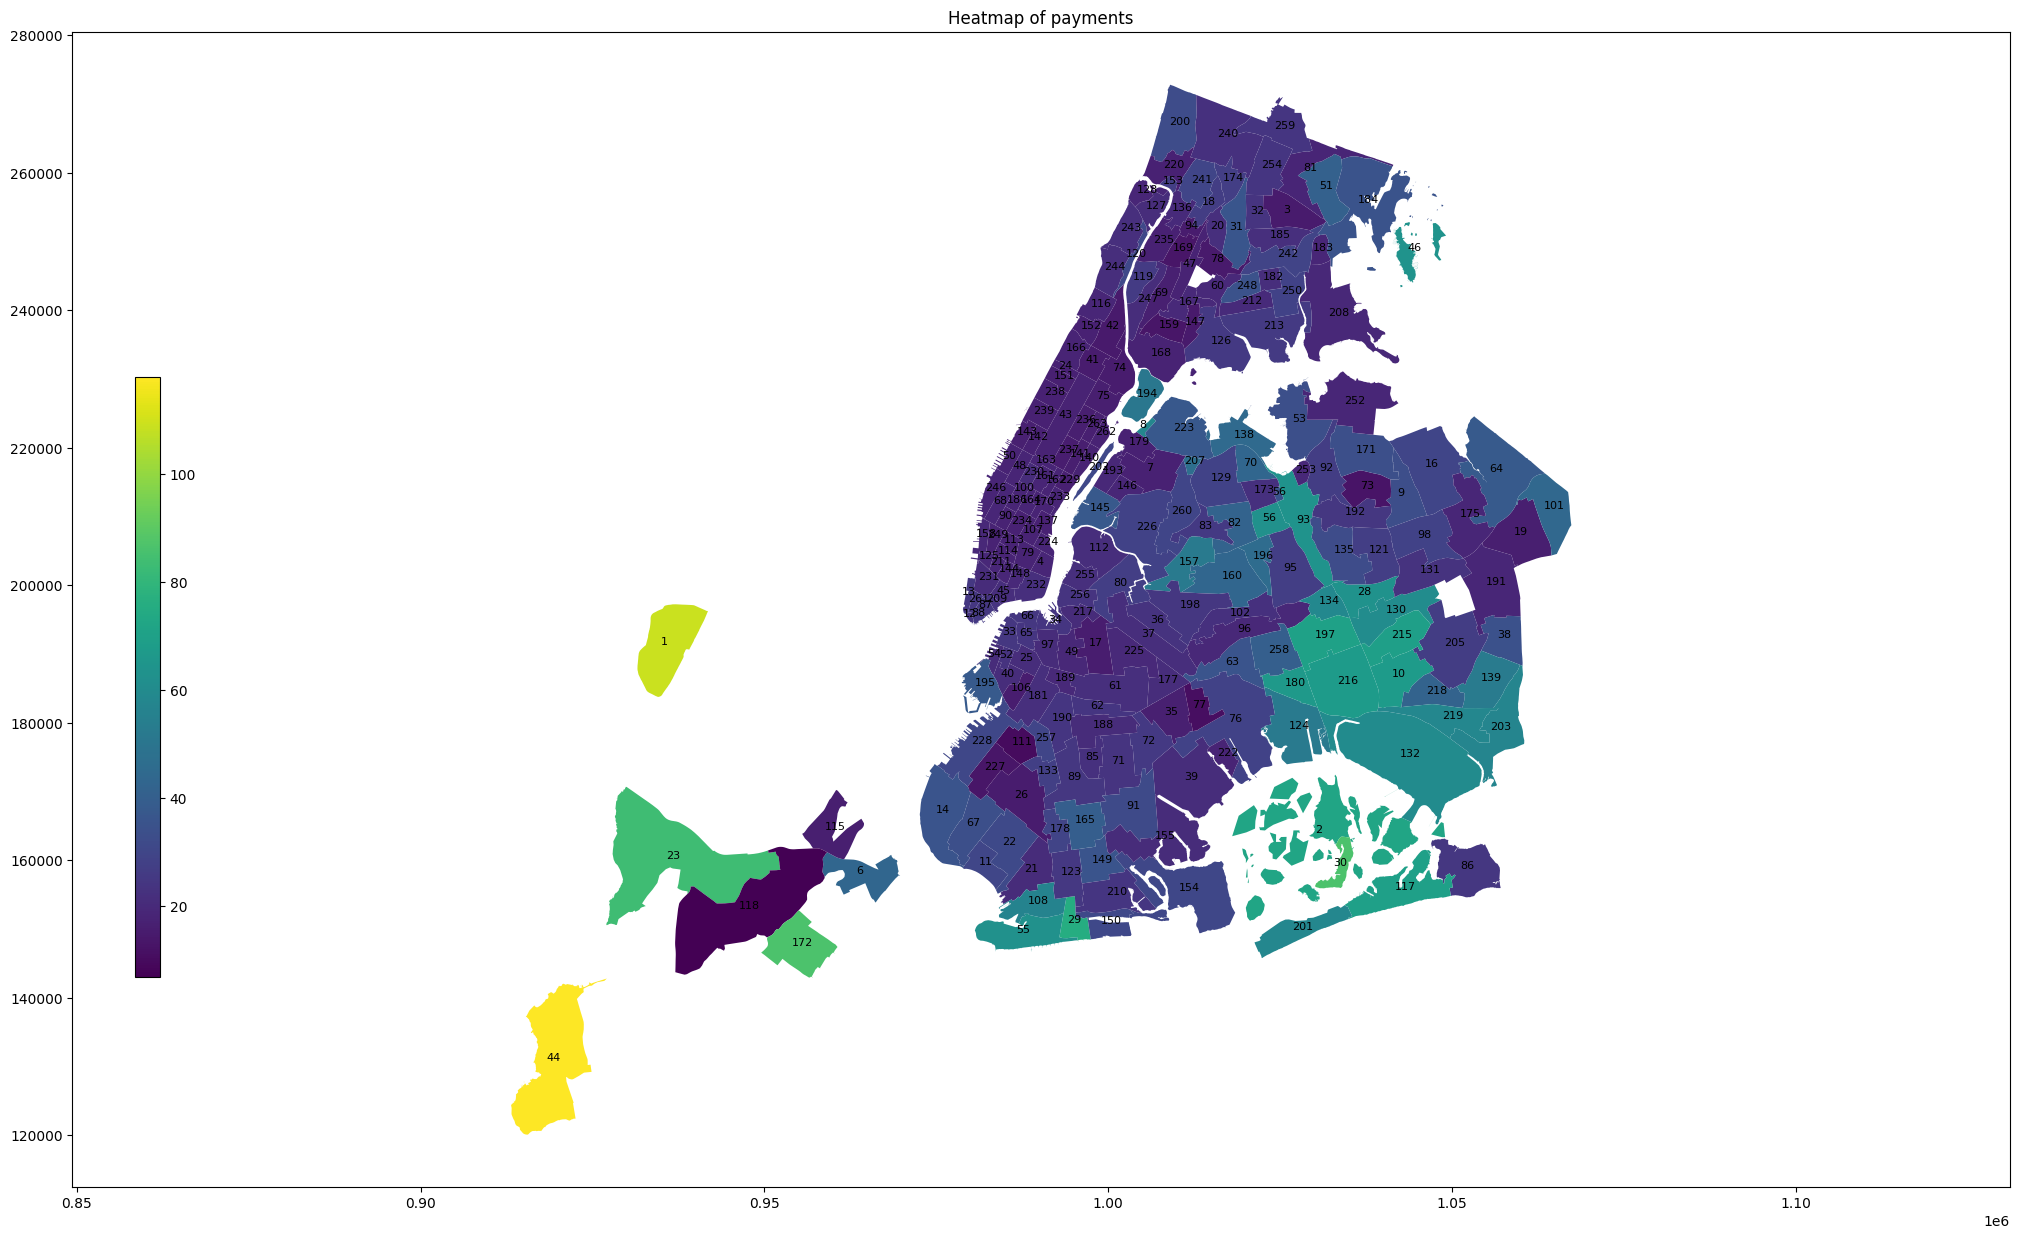

In [ ]:
# Total Ammount por PULocationID
dfPULocTA_all = df[['PULocationID','total_amount']].groupby('PULocationID').mean(numeric_only=True)
## Hago la union del geo_map con la agrupacion por total_amount
## La hago con OBJECTID porque parece que el LocationID está algo mal
geo_map2 = geo_map.set_index('OBJECTID').join(other=dfPULocTA_all, how='inner')


cmap = 'viridis'
fig, ax = plt.subplots(1, figsize=(25, 15))
ax = geo_map2.plot(ax=ax,column='total_amount', cmap = cmap, figsize=(15,10))
# ax = geo_map[~selection].plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
#ax.axis([lonmin, lonmax, latmin, latmax])

total_min = dfPULocTA_all.min()
total_max = dfPULocTA_all.max()

for x, y, label in zip(geo_map2.centroid.x, geo_map2.centroid.y, geo_map2['LocationID']):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 8)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of payments') 

### Variables de Salida
| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|total_amount          | float64    | Numerica| Monto total


### ¿Estan balanceadas las clases?
R/ Si

In [ ]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'month',
       'duration_m', 'day_of_year', 'day_week', 'day_type', 'log_duration'],
      dtype='object')

In [ ]:
s = df["trip_distance"].to_numpy().reshape(-1,1)

## 3. Limpieza y preparación de datos / ingeniería de features 

In [ ]:
1683952/1800428

0.9353064937892546

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675150 entries, 0 to 1675149
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   tpep_pickup_datetime   1675150 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  1675150 non-null  datetime64[ns]
 2   passenger_count        1675150 non-null  float32       
 3   trip_distance          1675150 non-null  float32       
 4   RatecodeID             1675150 non-null  category      
 5   PULocationID           1675150 non-null  category      
 6   DOLocationID           1675150 non-null  category      
 7   payment_type           1675150 non-null  uint8         
 8   fare_amount            1675150 non-null  float32       
 9   tip_amount             1675150 non-null  float32       
 10  tolls_amount           1675150 non-null  float32       
 11  total_amount           1675150 non-null  float32       
 12  airport_fee            16751

In [ ]:
df[(df['trip_distance'] > 100)].count()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
tolls_amount             0
total_amount             0
airport_fee              0
date                     0
time_of_day              0
month                    0
duration_m               0
day_of_year              0
day_week                 0
day_type                 0
log_duration             0
dtype: int64

In [ ]:
merged_df[(merged_df['trip_distance'] > 200)]

Empty DataFrame
Columns: [tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, tolls_amount, total_amount, airport_fee, date, time_of_day, month, duration_m, day_of_year, day_week, day_type, PU_borough, PU_zone, PU_service_zone, DO_borough, DO_zone, DO_service_zone]
Index: []

[0 rows x 26 columns]

### Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675150 entries, 0 to 1675149
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   tpep_pickup_datetime   1675150 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  1675150 non-null  datetime64[ns]
 2   passenger_count        1675150 non-null  float32       
 3   trip_distance          1675150 non-null  float32       
 4   RatecodeID             1675150 non-null  category      
 5   PULocationID           1675150 non-null  category      
 6   DOLocationID           1675150 non-null  category      
 7   payment_type           1675150 non-null  uint8         
 8   fare_amount            1675150 non-null  float32       
 9   tip_amount             1675150 non-null  float32       
 10  tolls_amount           1675150 non-null  float32       
 11  total_amount           1675150 non-null  float32       
 12  airport_fee            16751

In [ ]:
df.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
tolls_amount             0
total_amount             0
airport_fee              0
date                     0
time_of_day              0
month                    0
duration_m               0
day_of_year              0
day_week                 0
day_type                 0
log_duration             0
dtype: int64

In [ ]:
df['passenger_count'].isnull().groupby(df['RatecodeID']).count()

RatecodeID
1.0    1604017
2.0      62722
3.0       4047
4.0        183
5.0       4175
6.0          6
Name: passenger_count, dtype: int64

¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación 
recomendaría? Ensayar distintas técnicas y analizar los resultados. 

debido a lo discutido al inicio, la data solamente contiene datos faltantes cuando payment_type es 0, por lo tanto solamente dropeamos y nos quedamos sin Nans

### En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de  datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

En nuestro caso utiliamos one hot encoding para la variable day_type, vease abajo

Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de 
entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique 
brevemente los métodos utilizados

Las variables de mayor importancia son la distancia, y la duracion, la matriz de correlacion nos indica esto

# Modelo

In [ ]:
manhattan_df

passenger_count  trip_distance  PULocationID  DOLocationID  \
0                    1.0           2.12           142           161   
1                    1.0           1.40           142           161   
2                    1.0           1.20           142           161   
3                    2.0           1.36           142           161   
4                    1.0           0.81           142           161   
...                  ...            ...           ...           ...   
1666126              1.0           3.70           244           153   
1666127              1.0           0.95           127           153   
1666128              1.0           0.63           127           153   
1666130              2.0           0.01           153           153   
1675148              2.0           6.01           170           105   

         payment_type  total_amount  time_of_day  duration_m day_type  \
0                   2     15.300000           14   17.533333  weekend   
1                   1     16.600000           22   13.050000  workday   
2                   1     13.550000           23    8.466666  weekend   
3                   1     16.559999            9   14.933333  workday   
4                   1      9.300000           23    3.700000  workday   
...               ...           ...          ...         ...      ...   
1666126             2     13.800000           15   12.283334  workday   
1666127             2      7.300000           20    4.750000  workday   
1666128             2      5.300000            1    2.450000  weekend   
1666130             2     57.299999           19    0.283333  workday   
1675148             1     30.360001           13   22.100000  weekend   

         log_duration  log_trip  
0            2.864104  0.751416  
1            2.568788  0.336472  
2            2.136137  0.182322  
3            2.703596  0.307485  
4            1.308333 -0.210721  
...               ...       ...  
1666126      2.508243  1.308333  
1666127      1.558145 -0.051293  
1666128      0.896088 -0.462035  
1666130     -1.261131 -4.605170  
1675148      3.095578  1.793425  

[1425823 rows x 11 columns]

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.tree import BaseDecisionTree, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc,mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_metrics(ground_truth : list,predictions:list):
    print(classification_report(ground_truth,predictions))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(ground_truth,predictions),4))
    
    precision, recall,threshold=precision_recall_curve(ground_truth,predictions);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    print('Matriz de confusion')
    print(confusion_matrix(ground_truth, predictions))
    return

In [ ]:
model_df = pd.get_dummies(manhattan_df, columns = ['day_type'])

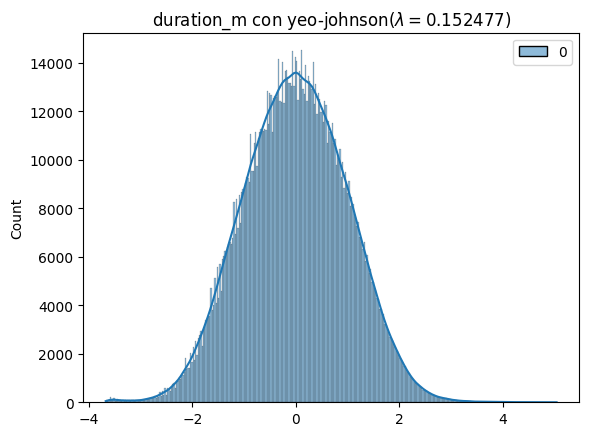

In [ ]:
model_df["duration_transformed"] = transform_variable(model_df, "duration_m")

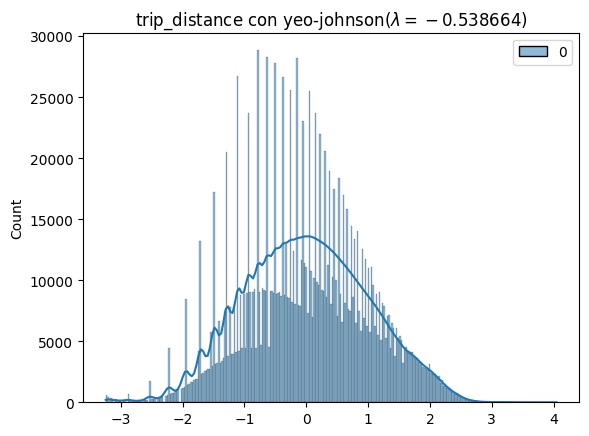

In [ ]:
model_df["trip_transformed"] = transform_variable(model_df, "trip_distance", )

<Axes: xlabel='log_trip', ylabel='Count'>

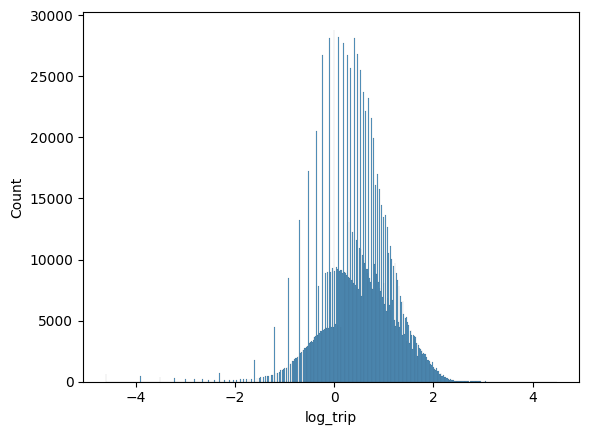

In [ ]:
sns.histplot(model_df.log_trip)

In [ ]:
model_df

passenger_count  trip_distance  PULocationID  DOLocationID  \
0                    1.0           2.12           142           161   
1                    1.0           1.40           142           161   
2                    1.0           1.20           142           161   
3                    2.0           1.36           142           161   
4                    1.0           0.81           142           161   
...                  ...            ...           ...           ...   
1666126              1.0           3.70           244           153   
1666127              1.0           0.95           127           153   
1666128              1.0           0.63           127           153   
1666130              2.0           0.01           153           153   
1675148              2.0           6.01           170           105   

         payment_type  total_amount  time_of_day  duration_m  log_duration  \
0                   2     15.300000           14   17.533333      2.864104   
1                   1     16.600000           22   13.050000      2.568788   
2                   1     13.550000           23    8.466666      2.136137   
3                   1     16.559999            9   14.933333      2.703596   
4                   1      9.300000           23    3.700000      1.308333   
...               ...           ...          ...         ...           ...   
1666126             2     13.800000           15   12.283334      2.508243   
1666127             2      7.300000           20    4.750000      1.558145   
1666128             2      5.300000            1    2.450000      0.896088   
1666130             2     57.299999           19    0.283333     -1.261131   
1675148             1     30.360001           13   22.100000      3.095578   

         log_trip  day_type_holiday  day_type_weekend  day_type_workday  \
0        0.751416                 0                 1                 0   
1        0.336472                 0                 0                 1   
2        0.182322                 0                 1                 0   
3        0.307485                 0                 0                 1   
4       -0.210721                 0                 0                 1   
...           ...               ...               ...               ...   
1666126  1.308333                 0                 0                 1   
1666127 -0.051293                 0                 0                 1   
1666128 -0.462035                 0                 1                 0   
1666130 -4.605170                 0                 0                 1   
1675148  1.793425                 0                 1                 0   

         duration_transformed  trip_transformed  
0                    0.857315          0.401996  
1                    0.333155         -0.259975  
2                   -0.376885         -0.500996  
3                    0.568489         -0.305654  
4                   -1.535581         -1.084396  
...                       ...               ...  
1666126              0.229626          1.265644  
1666127             -1.214501         -0.854383  
1666128             -2.009140         -1.423799  
1666130             -3.382236         -3.243318  
1675148              1.290283          1.943170  

[1425823 rows x 15 columns]

In [ ]:
model_df[['total_amount','duration_m']]

total_amount  duration_m
0           15.300000   17.533333
1           16.600000   13.050000
2           13.550000    8.466666
3           16.559999   14.933333
4            9.300000    3.700000
...               ...         ...
1666126     13.800000   12.283334
1666127      7.300000    4.750000
1666128      5.300000    2.450000
1666130     57.299999    0.283333
1675148     30.360001   22.100000

[1425823 rows x 2 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(['total_amount','log_duration','log_trip','duration_transformed', 'trip_transformed'], axis = 1), model_df['total_amount'])

In [ ]:
X_train

passenger_count  trip_distance  PULocationID  DOLocationID  \
1053074              1.0           1.49           163           262   
1149335              1.0           1.80           163           234   
354997               1.0           3.35           164           239   
853143               1.0           2.14           262           141   
1447977              3.0          10.55           211           244   
...                  ...            ...           ...           ...   
543868               1.0           3.27           229            75   
1408                 1.0           1.57           142           161   
539822               3.0           1.89           237            75   
1366436              2.0           2.60           163            79   
1013405              1.0           1.52            68            68   

         payment_type  time_of_day  duration_m  day_type_holiday  \
1053074             1           22    7.566667                 0   
1149335             1           10   11.950000                 0   
354997              2           11   32.266666                 0   
853143              1           20   11.733334                 0   
1447977             2            0   25.216667                 0   
...               ...          ...         ...               ...   
543868              1           12   13.450000                 0   
1408                1           13   10.266666                 0   
539822              1           19    6.216667                 0   
1366436             1           21   12.500000                 0   
1013405             2           22    7.266667                 0   

         day_type_weekend  day_type_workday  
1053074                 0                 1  
1149335                 0                 1  
354997                  0                 1  
853143                  0                 1  
1447977                 0                 1  
...                   ...               ...  
543868                  1                 0  
1408                    1                 0  
539822                  0                 1  
1366436                 0                 1  
1013405                 0                 1  

[1069367 rows x 10 columns]

In [ ]:
X_train.shape

(1069367, 10)

In [ ]:
X_test.shape

(356456, 10)

# Linear Regression

In [ ]:
def set_linear_regression(X_train,y_train):
    import numpy as np
    regr = LinearRegression()
    
    regr.fit(X_train, y_train)

    return regr

def scale_set(X_train, X_test):
  scaler=StandardScaler()  

  X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
  X_test_sc=scaler.transform(X_test)
  return (X_train_sc, X_test_sc)

In [ ]:
(X_train_sc, X_test_sc) = scale_set(X_train, X_test)

In [ ]:
regr = set_linear_regression(X_train_sc, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 15.938125793358996
Coefficients: 
 [ 2.30119316e-02  2.87045564e+00  1.27957452e-02  2.74916590e-02
 -1.01741134e+00  1.42049119e-01  3.18343656e+00  4.63746286e+11
  1.46069581e+12  1.49451487e+12]


In [ ]:
predictions = regr.predict(X_test_sc)

In [ ]:
#print("Coefficients: \n", mor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
print("Mean absolute error: %.2f" %  mean_absolute_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("r2 score: %.2f" % r2_score(y_test, predictions))


Mean squared error: 5.93
Mean absolute error: 0.96
r2 score: 0.85


# Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 100,n_jobs = -1, max_depth = 4, random_state = 42)
# Entrenamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_jobs=-1, random_state=42)

In [ ]:
predicciones = rf.predict(X_test)

# Calcular los errores absolutos
errores = abs(predicciones - y_test)

# Imprime el error absoluto medio (mae)
print('Error absoluto medio:', round(np.mean(errores), 2), 'dolares')

Error absoluto medio: 1.58 dolares


In [ ]:
#print("Coefficients: \n", mor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, predicciones))
print("Mean absolute error: %.2f" %  mean_absolute_error(y_test, predicciones))
# The coefficient of determination: 1 is perfect prediction
print("r2 score: %.2f" % r2_score(y_test, predicciones))

Mean squared error: 7.38
Mean absolute error: 1.58
r2 score: 0.81


In [ ]:
mape = 100 * (errores / y_test)
# Calcular y mostrar la precisión
precisión = 100 - np.mean(mape)
print('Precisión:', round(precisión, 2), '%.')

Precisión: 89.56 %.


In [ ]:
tree = rf.estimators_[5]

In [ ]:
print('La profundidad de este árbol es:', tree.tree_.max_depth)

La profundidad de este árbol es: 4


In [ ]:
model_df.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'time_of_day', 'duration_m',
       'log_duration', 'log_trip', 'day_type_holiday', 'day_type_weekend',
       'day_type_workday', 'duration_transformed', 'trip_transformed'],
      dtype='object')

In [ ]:
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: duration_m           Importance: 0.79
Variable: trip_distance        Importance: 0.19
Variable: payment_type         Importance: 0.02
Variable: passenger_count      Importance: 0.0
Variable: PULocationID         Importance: 0.0
Variable: DOLocationID         Importance: 0.0
Variable: time_of_day          Importance: 0.0
Variable: day_type_holiday     Importance: 0.0
Variable: day_type_weekend     Importance: 0.0
Variable: day_type_workday     Importance: 0.0


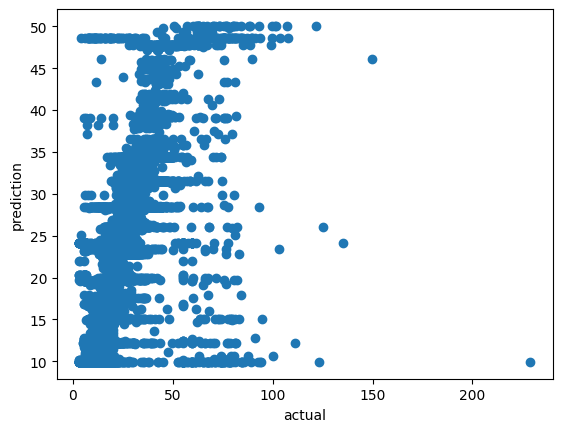

In [ ]:
plt.scatter(y_test,predicciones)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.show()

## Entrenando con las variables mas importantes segun el arbol anterior

In [ ]:
rf_most_important = RandomForestRegressor(n_estimators= 100,n_jobs = -1, max_depth = 4, random_state=42)


#important_indices = [model_df.columns.get_loc('trip_distance'), model_df.columns.get_loc('payment_type'), model_df.columns.get_loc('time_of_day')]
train_important = X_train.loc[:,["duration_m","trip_distance","payment_type"]]
test_important =X_test.loc[:,["duration_m","trip_distance","payment_type"]]
# Extraer las dos características más importantes
rf_most_important.fit(train_important, y_train)

# Hacer predicciones y determinar el error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions -y_test )

# Mostrar las métricas de rendimiento
print('Mean Absolute Error:', round(np.mean(errors), 2), 'dolares.')

mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.58 dolares.
Accuracy: 89.56 %.
